# 🏪 INVENTORY MANAGEMENT ANALYSIS
## Complete SQL & Machine Learning Analysis Dashboard

This notebook provides comprehensive inventory management analysis including:
- **Data Exploration & KPI Analysis**
- **Inventory Management Insights** 
- **Pricing & Promotion Analysis**
- **Forecast Accuracy Evaluation**
- **Machine Learning Forecasting**
- **Business Intelligence Dashboard**

---

## 🔧 SETUP & DATA LOADING

In [1]:
# =============================================================================
# LIBRARY IMPORTS & DATA LOADING
# =============================================================================

import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# Load CSV data into pandas DataFrame
print("📂 Loading inventory forecasting data...")
df = pd.read_csv('inventory_forecasting.csv')

# Preview the loaded data
print("✅ Data loaded successfully!")
print(f"📊 Dataset shape: {df.shape}")
df.head()

c:\MY FILES\Coding\SQL\proj\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


📂 Loading inventory forecasting data...
✅ Data loaded successfully!
📊 Dataset shape: (109500, 15)


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0096,Toys,West,158,134,142,152.36,40.88,5,Sunny,1,42.39,Winter
1,2022-01-01,S001,P0016,Clothing,East,189,127,125,150.47,90.78,0,Rainy,0,84.16,Winter
2,2022-01-01,S001,P0031,Electronics,West,75,48,39,68.62,13.99,20,Rainy,0,12.67,Winter
3,2022-01-01,S001,P0159,Electronics,West,161,74,71,75.46,84.92,10,Snowy,0,83.03,Winter
4,2022-01-01,S001,P0129,Furniture,South,135,66,69,67.18,19.66,0,Cloudy,0,20.55,Winter


In [2]:
# =============================================================================
# DATA QUALITY CHECK - NULL VALUES
# =============================================================================

# Check for missing values in the dataset
print("🔍 Checking data quality...")
null_counts = df.isnull().sum()
print("Missing values per column:")
null_counts

🔍 Checking data quality...
Missing values per column:


Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

In [3]:
# =============================================================================
# DATA PREPROCESSING - COLUMN STANDARDIZATION
# =============================================================================

# Rename columns to SQL-friendly format (remove spaces and special characters)
print("🔧 Standardizing column names for SQL compatibility...")
df.columns = [c.strip().replace(' ','_').replace('/','_') for c in df.columns]

print("✅ Column names standardized:")
print(f"📋 Final columns: {list(df.columns)}")
df.columns

🔧 Standardizing column names for SQL compatibility...
✅ Column names standardized:
📋 Final columns: ['Date', 'Store_ID', 'Product_ID', 'Category', 'Region', 'Inventory_Level', 'Units_Sold', 'Units_Ordered', 'Demand_Forecast', 'Price', 'Discount', 'Weather_Condition', 'Holiday_Promotion', 'Competitor_Pricing', 'Seasonality']


Index(['Date', 'Store_ID', 'Product_ID', 'Category', 'Region',
       'Inventory_Level', 'Units_Sold', 'Units_Ordered', 'Demand_Forecast',
       'Price', 'Discount', 'Weather_Condition', 'Holiday_Promotion',
       'Competitor_Pricing', 'Seasonality'],
      dtype='object')

In [4]:
# =============================================================================
# DATABASE SETUP - SQLite CONNECTION
# =============================================================================

# Create SQLite database connection
print("🗄️ Setting up SQLite database...")
conn = sqlite3.connect('retail.db')

# Import DataFrame into SQLite table
print("📤 Loading data into SQLite table 'InventoryData'...")
df.to_sql('InventoryData', conn, if_exists='replace', index=False)

print("✅ Database setup complete!")
print(f"📊 Table 'InventoryData' created with {len(df)} records")

🗄️ Setting up SQLite database...
📤 Loading data into SQLite table 'InventoryData'...
✅ Database setup complete!
📊 Table 'InventoryData' created with 109500 records


In [5]:
# =============================================================================
# QUERY 1A: DISTINCT PRODUCT CATEGORIES
# =============================================================================

# Get all unique product categories in the inventory
gquery_1 = """
SELECT DISTINCT Category FROM InventoryData
"""
pd.read_sql_query(gquery_1, conn)

,Category
0,Toys
1,Clothing
2,Electronics
3,Furniture
4,Groceries


---

## 📊 BASIC DATA EXPLORATION

In [6]:
# =============================================================================
# QUERY 1B: CATEGORY-PRODUCT COMBINATIONS
# =============================================================================

# Get all unique category and product combinations
gquery_1b = """
SELECT DISTINCT Category, Product_ID
FROM InventoryData
ORDER BY Category, Product_ID
"""

print("📦 Category-Product Combinations:")
result_1b = pd.read_sql_query(gquery_1b, conn)
print(f"Total combinations: {len(result_1b)}")
result_1b

📦 Category-Product Combinations:
Total combinations: 30


,Category,Product_ID
0,Clothing,P0016
1,Clothing,P0046
2,Clothing,P0057
3,Clothing,P0061
4,Clothing,P0066
5,Clothing,P0069
6,Clothing,P0125
7,Clothing,P0126
8,Clothing,P0133
9,Clothing,P0178


In [32]:
# =============================================================================
# QUERY 2A: STORE-LEVEL KPIs BY CATEGORY
# =============================================================================

# Calculate comprehensive KPIs for each store across all categories
# Metrics: Sell-Through Rate, Inventory Turnover, Order-Sales Ratio
gquery_2 = """
SELECT 
    Store_ID,

    -- Electronics KPIs
    SUM(CASE WHEN Category = 'Electronics' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Electronics' THEN Inventory_Level ELSE 0 END), 0) AS Electronics_Sell_Through_Rate,

    SUM(CASE WHEN Category = 'Electronics' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(AVG(CASE WHEN Category = 'Electronics' THEN Inventory_Level ELSE 0 END), 0) AS Electronics_Inventory_Turnover,

    SUM(CASE WHEN Category = 'Electronics' THEN Units_Ordered ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Electronics' THEN Units_Sold ELSE 0 END), 0) AS Electronics_Order_Sales_Ratio,

    -- Grocery KPIs
    SUM(CASE WHEN Category = 'Groceries' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Groceries' THEN Inventory_Level ELSE 0 END), 0) AS Grocery_Sell_Through_Rate,

    SUM(CASE WHEN Category = 'Groceries' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(AVG(CASE WHEN Category = 'Groceries' THEN Inventory_Level ELSE 0 END), 0) AS Grocery_Inventory_Turnover,

    SUM(CASE WHEN Category = 'Groceries' THEN Units_Ordered ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Groceries' THEN Units_Sold ELSE 0 END), 0) AS Grocery_Order_Sales_Ratio,

    -- Clothing KPIs
    SUM(CASE WHEN Category = 'Clothing' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Clothing' THEN Inventory_Level ELSE 0 END), 0) AS Clothing_Sell_Through_Rate,

    SUM(CASE WHEN Category = 'Clothing' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(AVG(CASE WHEN Category = 'Clothing' THEN Inventory_Level ELSE 0 END), 0) AS Clothing_Inventory_Turnover,

    SUM(CASE WHEN Category = 'Clothing' THEN Units_Ordered ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Clothing' THEN Units_Sold ELSE 0 END), 0) AS Clothing_Order_Sales_Ratio,

    -- Furniture KPIs
    SUM(CASE WHEN Category = 'Furniture' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Furniture' THEN Inventory_Level ELSE 0 END), 0) AS Furniture_Sell_Through_Rate,

    SUM(CASE WHEN Category = 'Furniture' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(AVG(CASE WHEN Category = 'Furniture' THEN Inventory_Level ELSE 0 END), 0) AS Furniture_Inventory_Turnover,

    SUM(CASE WHEN Category = 'Furniture' THEN Units_Ordered ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Furniture' THEN Units_Sold ELSE 0 END), 0) AS Furniture_Order_Sales_Ratio,

        -- Toys KPIs
    SUM(CASE WHEN Category = 'Toys' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Toys' THEN Inventory_Level ELSE 0 END), 0) AS Toys_Sell_Through_Rate,

    SUM(CASE WHEN Category = 'Toys' THEN Units_Sold ELSE 0 END) * 1.0 / 
    NULLIF(AVG(CASE WHEN Category = 'Toys' THEN Inventory_Level ELSE 0 END), 0) AS Toys_Inventory_Turnover,

    SUM(CASE WHEN Category = 'Toys' THEN Units_Ordered ELSE 0 END) * 1.0 / 
    NULLIF(SUM(CASE WHEN Category = 'Toys' THEN Units_Sold ELSE 0 END), 0) AS Toys_Order_Sales_Ratio

FROM InventoryData
GROUP BY Store_ID;
"""

print("🏪 Store-Level KPIs by Category:")
df_kpi_by_store = pd.read_sql_query(gquery_2, conn)
print(f"📊 Shape: {df_kpi_by_store.shape}")
df_kpi_by_store

🏪 Store-Level KPIs by Category:
📊 Shape: (5, 16)


,Store_ID,Electronics_Sell_Through_Rate,Electronics_Inventory_Turnover,Electronics_Order_Sales_Ratio,Grocery_Sell_Through_Rate,Grocery_Inventory_Turnover,Grocery_Order_Sales_Ratio,Clothing_Sell_Through_Rate,Clothing_Inventory_Turnover,Clothing_Order_Sales_Ratio,Furniture_Sell_Through_Rate,Furniture_Inventory_Turnover,Furniture_Order_Sales_Ratio,Toys_Sell_Through_Rate,Toys_Inventory_Turnover,Toys_Order_Sales_Ratio
0,S001,0.644862,14122.474926,0.993211,0.665845,14582.011837,0.993477,0.680320,14899.008413,0.997225,0.655276,14350.543654,0.996854,0.659208,14436.647102,0.994189
1,S002,0.643149,14084.972166,0.991675,0.666414,14594.462374,0.996116,0.681313,14920.757799,0.995836,0.650973,14256.317924,0.995700,0.651230,14261.939521,0.997545
2,S003,0.642635,14073.706275,0.994203,0.676072,14805.966058,0.996752,0.682382,14944.172573,0.996715,0.659598,14445.198270,0.991541,0.659125,14434.845250,0.992026
3,S004,0.640984,14037.550535,0.994957,0.670816,14690.877612,0.996436,0.682520,14947.177362,0.996307,0.655193,14348.723071,0.994944,0.651030,14257.555424,0.999670
4,S005,0.644579,14116.283401,0.995139,0.678035,14848.972820,0.992473,0.682166,14939.441085,0.999823,0.658338,14417.598233,0.995055,0.659501,14443.061889,0.995739


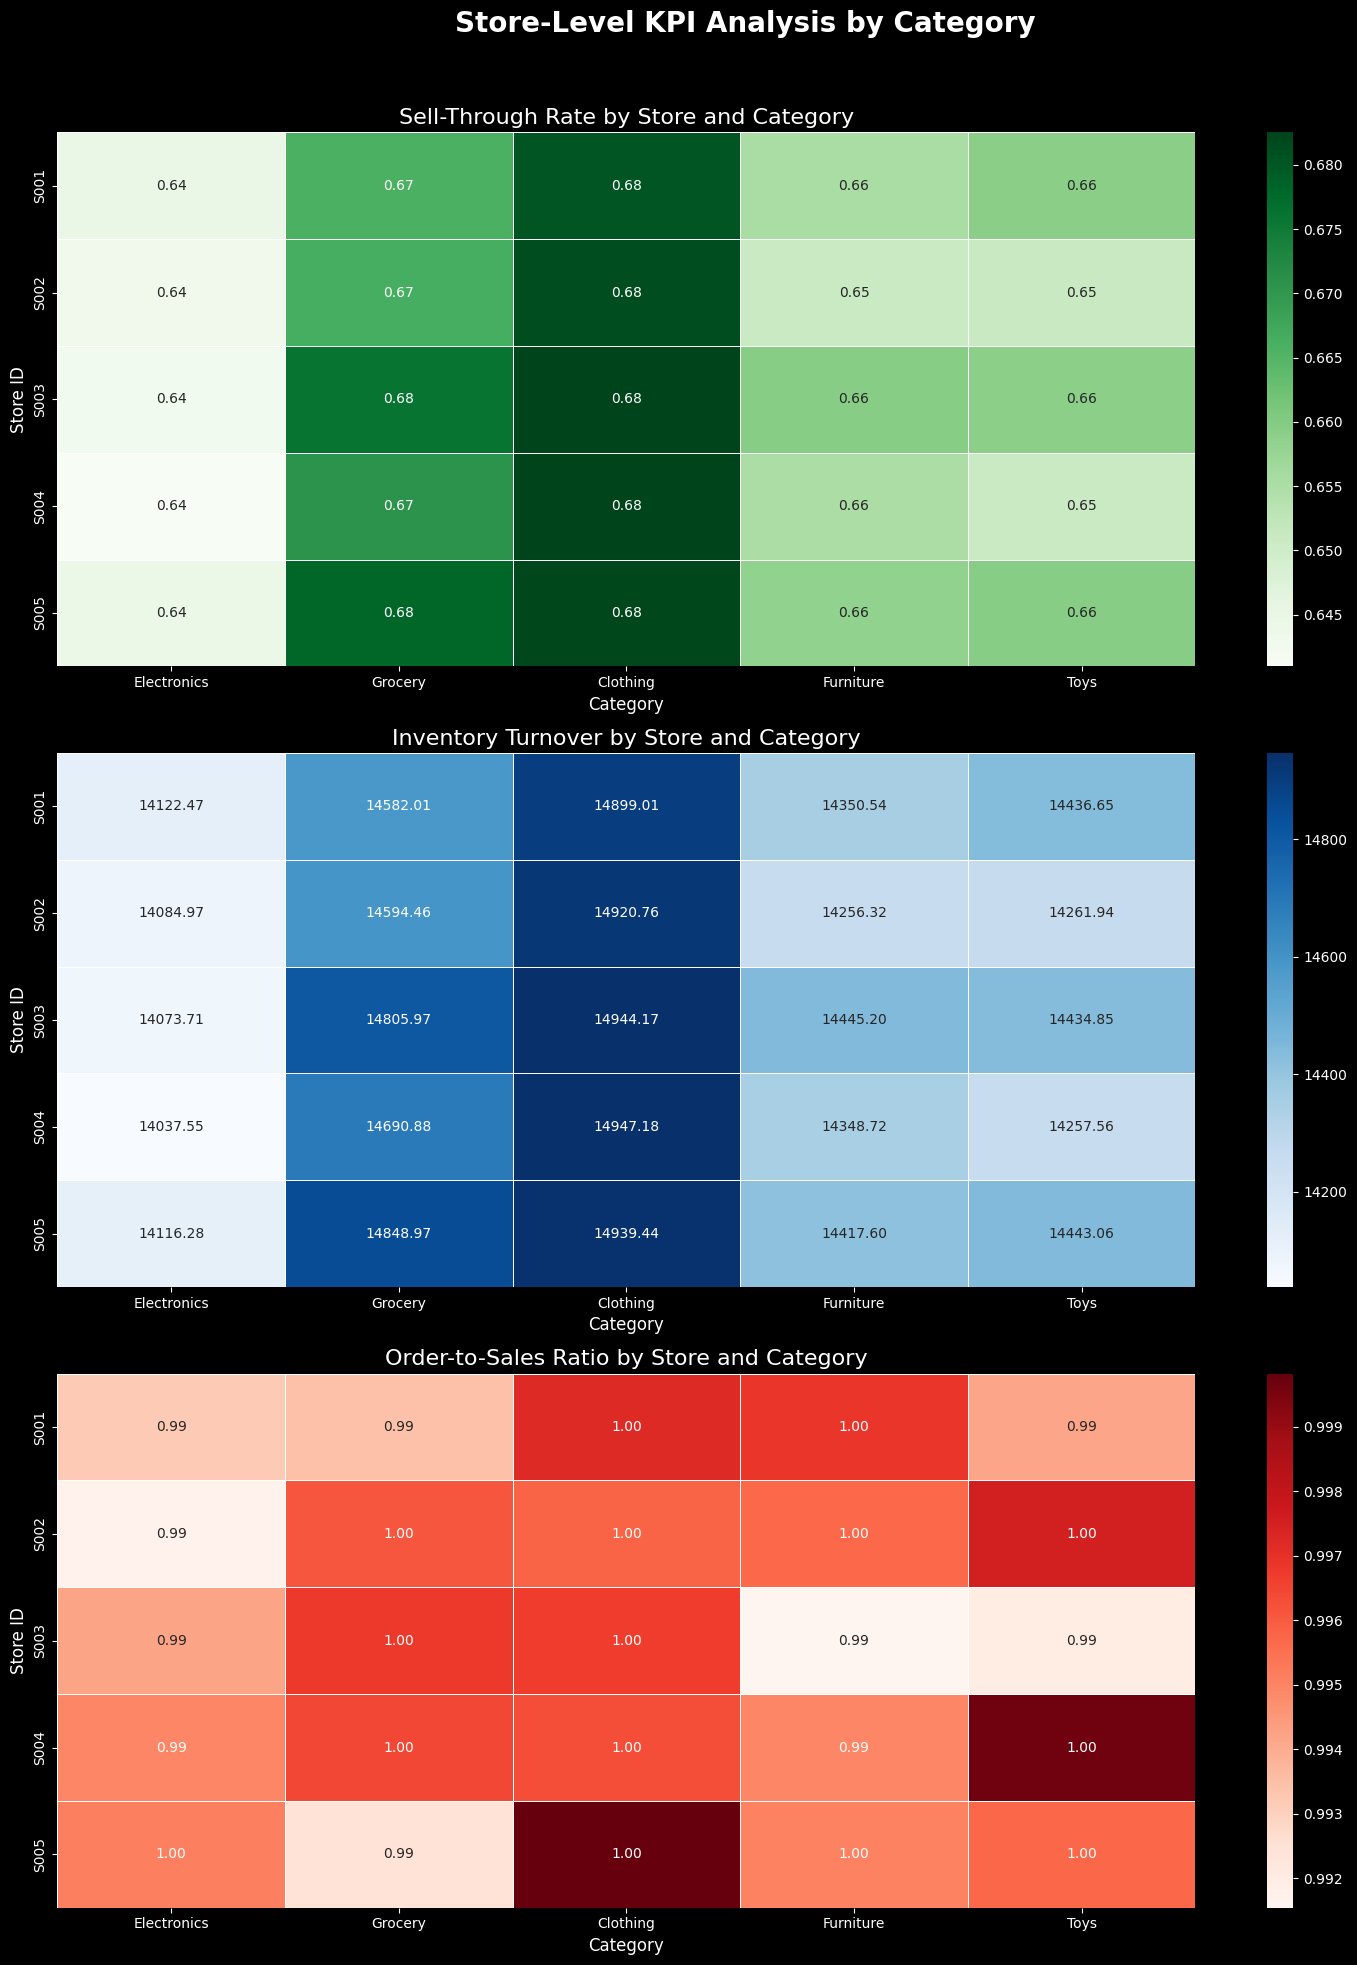

In [33]:
# =============================================================================
# VISUALIZATION OF STORE-LEVEL KPIs
# =============================================================================

# Set up the figure for multiple plots
fig, axes = plt.subplots(3, 1, figsize=(15, 20))
fig.suptitle('Store-Level KPI Analysis by Category', fontsize=20, fontweight='bold')

# --- 1. Sell-Through Rate Heatmap ---
sell_through_cols = [col for col in df_kpi_by_store.columns if 'Sell_Through_Rate' in col]
df_sell_through = df_kpi_by_store[['Store_ID'] + sell_through_cols].set_index('Store_ID')
df_sell_through.columns = [c.replace('_Sell_Through_Rate', '') for c in df_sell_through.columns]

sns.heatmap(df_sell_through, annot=True, fmt=".2f", cmap="Greens", ax=axes[0], linewidths=.5)
axes[0].set_title('Sell-Through Rate by Store and Category', fontsize=16)
axes[0].set_xlabel('Category', fontsize=12)
axes[0].set_ylabel('Store ID', fontsize=12)

# --- 2. Inventory Turnover Heatmap ---
inventory_turnover_cols = [col for col in df_kpi_by_store.columns if 'Inventory_Turnover' in col]
df_inventory_turnover = df_kpi_by_store[['Store_ID'] + inventory_turnover_cols].set_index('Store_ID')
df_inventory_turnover.columns = [c.replace('_Inventory_Turnover', '') for c in df_inventory_turnover.columns]

sns.heatmap(df_inventory_turnover, annot=True, fmt=".2f", cmap="Blues", ax=axes[1], linewidths=.5)
axes[1].set_title('Inventory Turnover by Store and Category', fontsize=16)
axes[1].set_xlabel('Category', fontsize=12)
axes[1].set_ylabel('Store ID', fontsize=12)

# --- 3. Order-Sales Ratio Heatmap ---
order_sales_cols = [col for col in df_kpi_by_store.columns if 'Order_Sales_Ratio' in col]
df_order_sales = df_kpi_by_store[['Store_ID'] + order_sales_cols].set_index('Store_ID')
df_order_sales.columns = [c.replace('_Order_Sales_Ratio', '') for c in df_order_sales.columns]

sns.heatmap(df_order_sales, annot=True, fmt=".2f", cmap="Reds", ax=axes[2], linewidths=.5)
axes[2].set_title('Order-to-Sales Ratio by Store and Category', fontsize=16)
axes[2].set_xlabel('Category', fontsize=12)
axes[2].set_ylabel('Store ID', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

---

## 📈 KEY PERFORMANCE INDICATORS (KPI) ANALYSIS

In [34]:
# =============================================================================
# QUERY 2B: PRODUCT-LEVEL KPIs 
# =============================================================================

# Calculate KPIs for each product-store combination
gquery_3 = """
SELECT 
    Store_ID,
    Product_ID,

    SUM(Units_Sold) * 1.0 / 
    NULLIF(SUM(Inventory_Level), 0) AS Sell_Through_Rate,

    SUM(Units_Sold) * 1.0 / 
    NULLIF(AVG(Inventory_Level), 0) AS Inventory_Turnover,

    SUM(Units_Ordered) * 1.0 / 
    NULLIF(SUM(Units_Sold), 0) AS Order_Sales_Ratio

FROM InventoryData
GROUP BY Store_ID, Product_ID;
"""

print("📦 Product-Level KPIs:")
df_kpi_by_product = pd.read_sql_query(gquery_3, conn)
print(f"📊 Shape: {df_kpi_by_product.shape}")
df_kpi_by_product


📦 Product-Level KPIs:
📊 Shape: (150, 5)


,Store_ID,Product_ID,Sell_Through_Rate,Inventory_Turnover,Order_Sales_Ratio
0,S001,P0016,0.677669,494.698545,0.993979
1,S001,P0017,0.661657,483.009725,0.998755
2,S001,P0031,0.650225,474.664495,0.997864
3,S001,P0046,0.687716,502.032973,0.999445
4,S001,P0057,0.677688,494.712315,1.000538
...,...,...,...,...,...
145,S005,P0171,0.632769,461.921718,1.000062
146,S005,P0175,0.646533,471.969369,0.994334
147,S005,P0178,0.690914,504.367042,0.998771
148,S005,P0183,0.653887,477.337531,1.002131


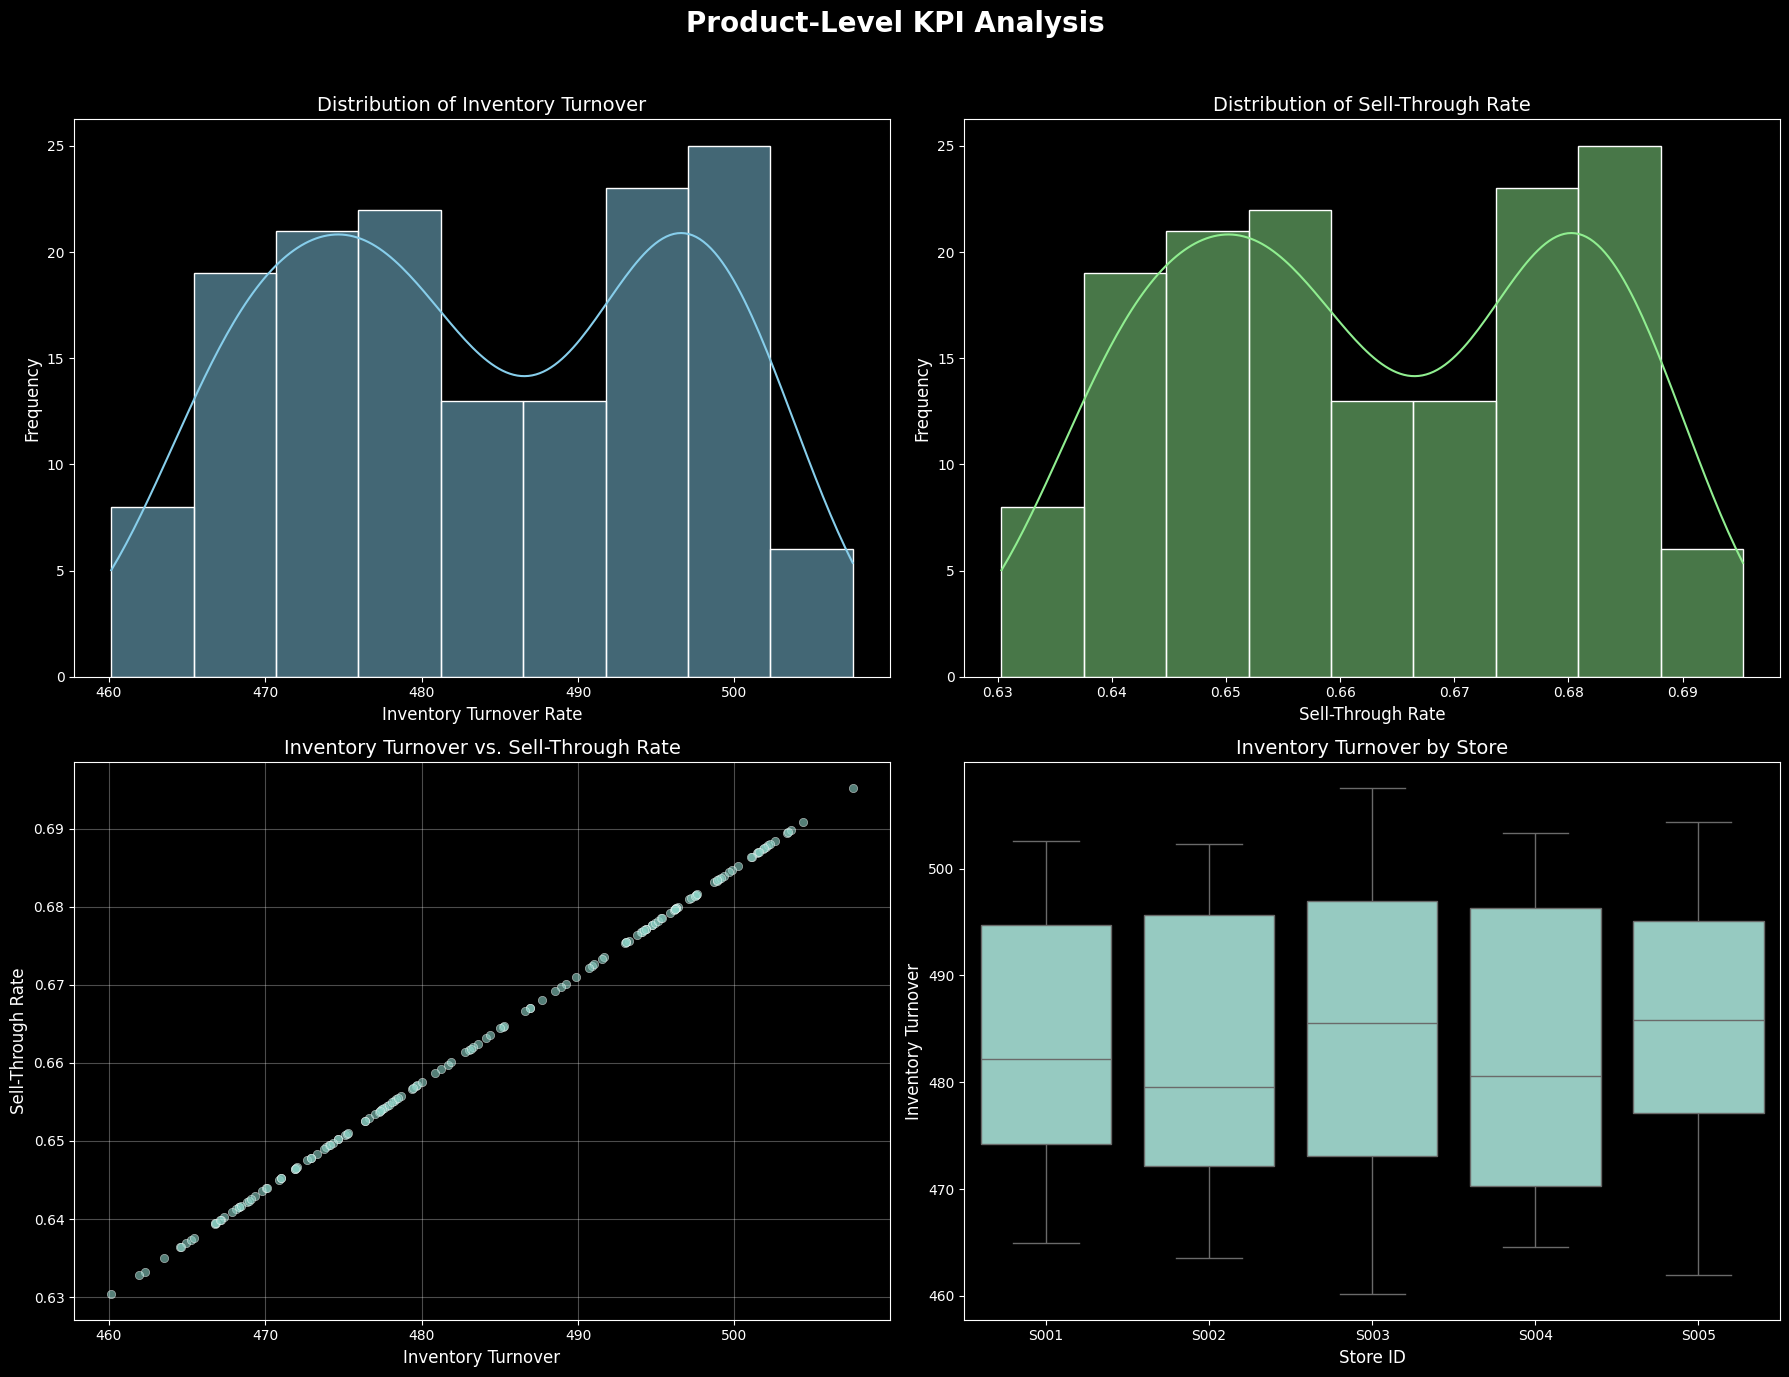

In [35]:
# =============================================================================
# VISUALIZATION OF PRODUCT-LEVEL KPIs
# =============================================================================

# Set up the figure for multiple plots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Product-Level KPI Analysis', fontsize=20, fontweight='bold')

# --- 1. Distribution of Inventory Turnover ---
sns.histplot(data=df_kpi_by_product, x='Inventory_Turnover', kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribution of Inventory Turnover', fontsize=14)
axes[0, 0].set_xlabel('Inventory Turnover Rate', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)

# --- 2. Distribution of Sell-Through Rate ---
sns.histplot(data=df_kpi_by_product, x='Sell_Through_Rate', kde=True, ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Distribution of Sell-Through Rate', fontsize=14)
axes[0, 1].set_xlabel('Sell-Through Rate', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)

# --- 3. Inventory Turnover vs. Sell-Through Rate ---
sns.scatterplot(data=df_kpi_by_product, x='Inventory_Turnover', y='Sell_Through_Rate', alpha=0.6, ax=axes[1, 0])
axes[1, 0].set_title('Inventory Turnover vs. Sell-Through Rate', fontsize=14)
axes[1, 0].set_xlabel('Inventory Turnover', fontsize=12)
axes[1, 0].set_ylabel('Sell-Through Rate', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# --- 4. Inventory Turnover by Store ---
sns.boxplot(data=df_kpi_by_product, x='Store_ID', y='Inventory_Turnover', ax=axes[1, 1])
axes[1, 1].set_title('Inventory Turnover by Store', fontsize=14)
axes[1, 1].set_xlabel('Store ID', fontsize=12)
axes[1, 1].set_ylabel('Inventory Turnover', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [9]:
# =============================================================================
# QUERY 2C: ANOMALY DETECTION - ORDER-SALES RATIO DEVIATIONS
# =============================================================================

# Identify products with order-sales ratios outside normal range (±2%)
gquery_4 = """
SELECT *
FROM (
    SELECT 
        Store_ID,
        Product_ID,

        SUM(Units_Sold) * 1.0 / 
        NULLIF(SUM(Inventory_Level), 0) AS Sell_Through_Rate,

        SUM(Units_Sold) * 1.0 / 
        NULLIF(AVG(Inventory_Level), 0) AS Inventory_Turnover,

        SUM(Units_Ordered) * 1.0 / 
        NULLIF(SUM(Units_Sold), 0) AS Order_Sales_Ratio

    FROM InventoryData
    GROUP BY Store_ID, Product_ID
) AS sub
WHERE Order_Sales_Ratio > 1.02 OR Order_Sales_Ratio < 0.98;
"""

print("⚠️ Products with Anomalous Order-Sales Ratios (>2% deviation):")
df_kpi_anom_2per = pd.read_sql_query(gquery_4, conn)
print(f"🔍 Found {len(df_kpi_anom_2per)} anomalous product-store combinations")
df_kpi_anom_2per


⚠️ Products with Anomalous Order-Sales Ratios (>2% deviation):
🔍 Found 0 anomalous product-store combinations


,Store_ID,Product_ID,Sell_Through_Rate,Inventory_Turnover,Order_Sales_Ratio


In [10]:
# =============================================================================
# QUERY 3A: CURRENT STOCK LEVELS BY STORE AND PRODUCT
# =============================================================================

# Get current inventory levels for all product-store combinations
query1_storewise = """
SELECT Product_ID, Store_ID, Inventory_Level
FROM InventoryData
WHERE Date = (SELECT MAX(Date) FROM InventoryData)
ORDER BY Product_ID, Store_ID;
"""

print("📊 Current Stock Levels (Latest Date):")
result_current_stock = pd.read_sql_query(query1_storewise, conn)
print(f"📦 Total records: {len(result_current_stock)}")
result_current_stock

📊 Current Stock Levels (Latest Date):
📦 Total records: 150


,Product_ID,Store_ID,Inventory_Level
0,P0016,S001,111
1,P0016,S002,277
2,P0016,S003,228
3,P0016,S004,248
4,P0016,S005,240
...,...,...,...
145,P0187,S001,245
146,P0187,S002,115
147,P0187,S003,193
148,P0187,S004,130


---

## 📦 INVENTORY MANAGEMENT ANALYSIS

In [42]:
# =============================================================================
# QUERY 3B: LOW INVENTORY ALERT SYSTEM
# =============================================================================

# Identify products where current inventory is below demand forecast
query2 = """
SELECT Date, Product_ID,Category, Store_ID, Inventory_Level, Demand_Forecast,
       (Demand_Forecast - Inventory_Level) AS Shortage_Amount
FROM InventoryData
WHERE Inventory_Level < Demand_Forecast
ORDER BY Date, Shortage_Amount DESC;
"""

print("🚨 Low Inventory Alert System:")
result_low_inventory = pd.read_sql_query(query2, conn)
print(f"⚠️ Total alerts: {len(result_low_inventory)}")
print("📊 Top alerts by shortage amount:")
result_low_inventory

🚨 Low Inventory Alert System:
⚠️ Total alerts: 16272
📊 Top alerts by shortage amount:


,Date,Product_ID,Category,Store_ID,Inventory_Level,Demand_Forecast,Shortage_Amount
0,2022-01-01,P0187,Clothing,S003,109,159.10,50.10
1,2022-01-01,P0129,Furniture,S005,115,155.88,40.88
2,2022-01-01,P0166,Groceries,S003,101,136.95,35.95
3,2022-01-01,P0069,Clothing,S002,166,195.10,29.10
4,2022-01-01,P0057,Clothing,S003,115,139.64,24.64
...,...,...,...,...,...,...,...
16267,2023-12-31,P0031,Electronics,S002,78,83.43,5.43
16268,2023-12-31,P0126,Clothing,S004,67,72.15,5.15
16269,2023-12-31,P0083,Toys,S005,71,75.96,4.96
16270,2023-12-31,P0085,Electronics,S002,51,55.36,4.36


C:\Users\dsain\AppData\Local\Temp\ipykernel_23144\2855384760.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=results_low_inventory_lessthen_50, y='Category', order=results_low_inventory_lessthen_50['Category'].value_counts().index, palette='viridis')


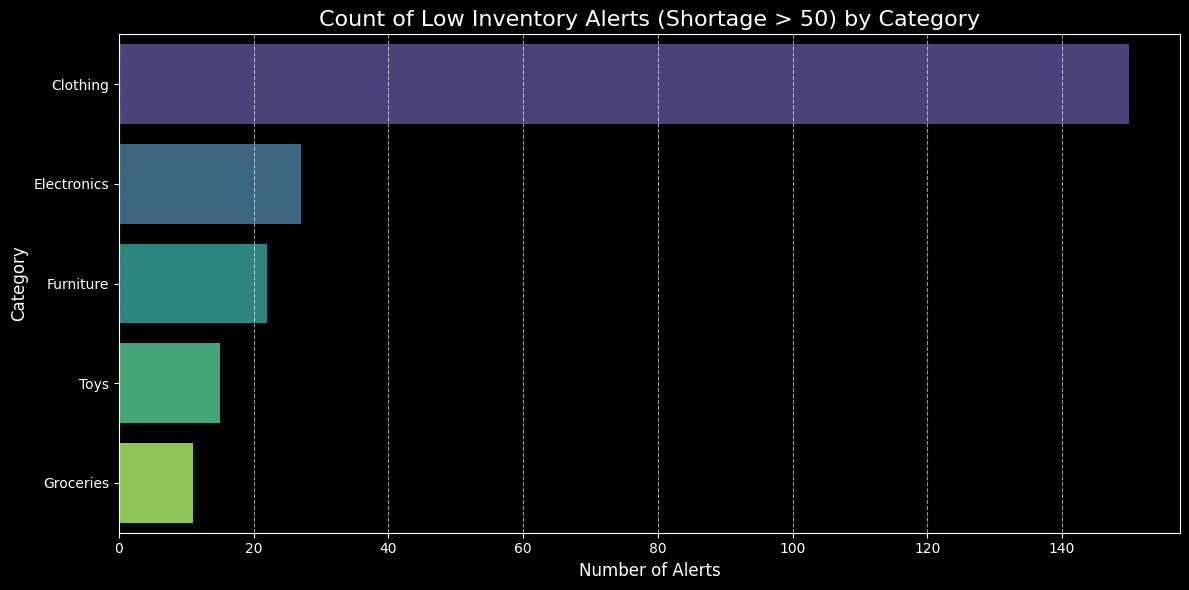

In [44]:
results_low_inventory_lessthen_50 = result_low_inventory[result_low_inventory['Shortage_Amount'] > 50].sort_values(by='Shortage_Amount', ascending=False)

# =============================================================================
# VISUALIZATION OF LOW INVENTORY ALERTS BY CATEGORY
# =============================================================================

# Create a bar plot to show the number of significant low inventory alerts for each category
plt.figure(figsize=(12, 6))
sns.countplot(data=results_low_inventory_lessthen_50, y='Category', order=results_low_inventory_lessthen_50['Category'].value_counts().index, palette='viridis')
plt.title('Count of Low Inventory Alerts (Shortage > 50) by Category', fontsize=16)
plt.xlabel('Number of Alerts', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

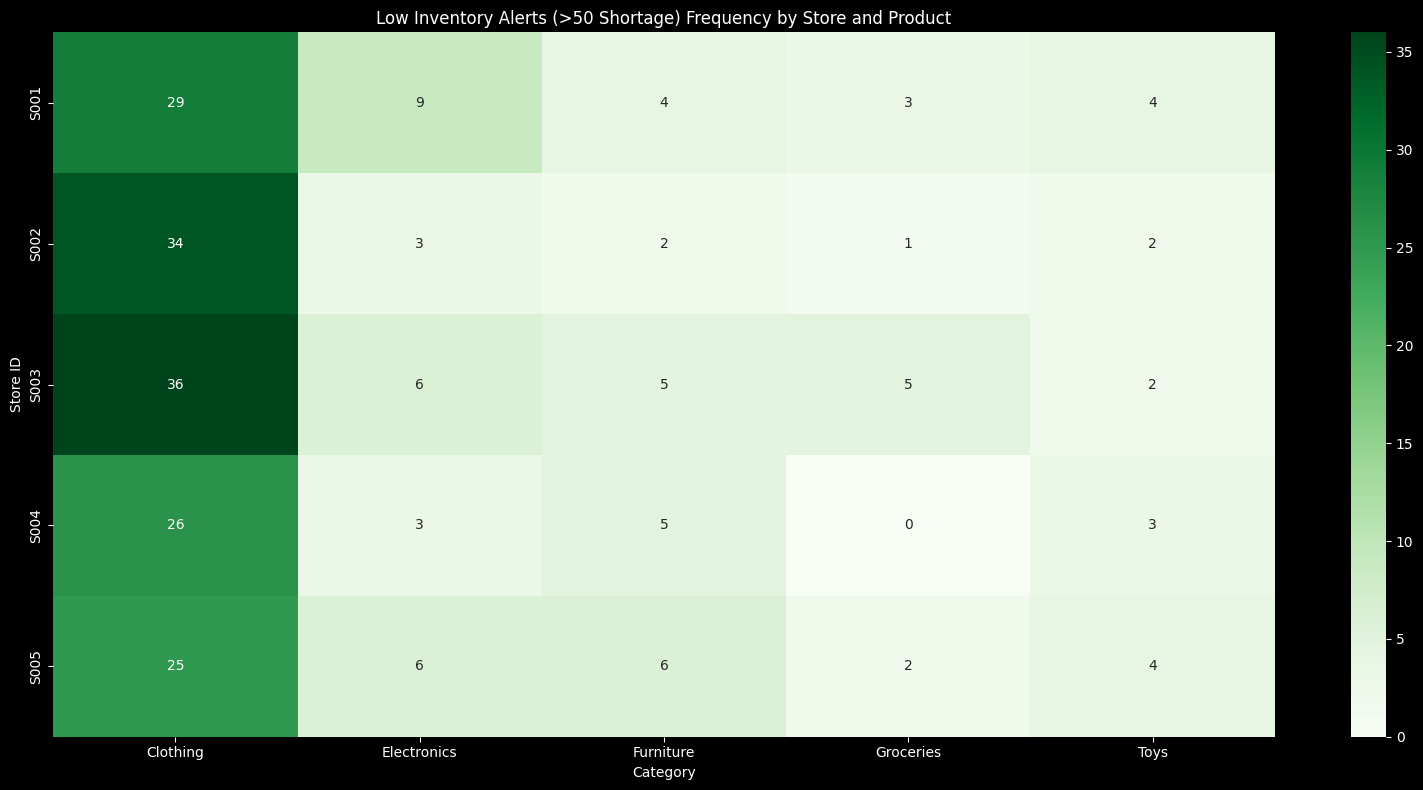

In [46]:
# Pivot the results_low_inventory_lessthen_50 DataFrame to get frequency of shortages by Store and Product
pivot_alerts = results_low_inventory_lessthen_50.pivot_table(
    index='Store_ID',
    columns='Category',
    values='Shortage_Amount',
    aggfunc='count',
    fill_value=0
)

plt.figure(figsize=(16, 8))
sns.heatmap(pivot_alerts, annot=True, fmt='d', cmap='Greens')
plt.title('Low Inventory Alerts (>50 Shortage) Frequency by Store and Product')
plt.xlabel('Category')
plt.ylabel('Store ID')
plt.tight_layout()
plt.show()

In [12]:
# =============================================================================
# QUERY 3C: 7-DAY ROLLING SALES AVERAGE
# =============================================================================

# Calculate 7-day rolling average sales to approximate demand patterns
query3 = """
SELECT Product_ID,
       ROUND(AVG(Units_Sold),2) AS Avg_7Day_Sales,
       COUNT(*) AS Days_In_Period
FROM InventoryData
WHERE Date >= (
   SELECT DATE(MAX(Date), '-6 day')
   FROM InventoryData
)
GROUP BY Product_ID
ORDER BY Avg_7Day_Sales DESC;
"""

print("📈 7-Day Rolling Sales Average (Demand Approximation):")
result_7day_avg = pd.read_sql_query(query3, conn)
print(f"📊 Products analyzed: {len(result_7day_avg)}")
result_7day_avg

📈 7-Day Rolling Sales Average (Demand Approximation):


📊 Products analyzed: 30


,Product_ID,Avg_7Day_Sales,Days_In_Period
0,P0016,135.89,35
1,P0133,133.94,35
2,P0187,133.60,35
3,P0125,132.31,35
4,P0057,132.17,35
5,P0061,127.77,35
6,P0126,127.74,35
7,P0066,127.51,35
8,P0178,123.03,35
9,P0046,121.80,35


In [49]:
# =============================================================================
# QUERY 3D: INVENTORY TURNOVER ANALYSIS
# =============================================================================

# Calculate inventory turnover rates to identify fast/slow-moving products
# High turnover = fast-moving product requiring frequent restocking
query4 = """
SELECT Product_ID,
       SUM(Units_Sold) as Total_Sales,
       AVG(Inventory_Level) as Avg_Inventory,
       ROUND(SUM(Units_Sold)/AVG(Inventory_Level),2) AS Inventory_Turnover,
       COUNT(DISTINCT Date) AS Days_Tracked
FROM InventoryData
GROUP BY Product_ID
ORDER BY Inventory_Turnover DESC;
"""

print("🔄 Inventory Turnover Analysis:")
result_turnover = pd.read_sql_query(query4, conn)
print(f"📊 Products analyzed: {len(result_turnover)}")
print("🏆 Top performers (fastest moving):")
result_turnover.sort_values(by='Inventory_Turnover', ascending=False)

🔄 Inventory Turnover Analysis:
📊 Products analyzed: 30
🏆 Top performers (fastest moving):


,Product_ID,Total_Sales,Avg_Inventory,Inventory_Turnover,Days_Tracked
0,P0046,386805,154.506301,2503.49,730
1,P0133,385843,154.356986,2499.68,730
2,P0057,387209,155.087945,2496.71,730
3,P0178,384440,153.986575,2496.58,730
4,P0187,385583,154.869315,2489.73,730
5,P0066,384764,154.667123,2487.69,730
6,P0125,385137,154.882192,2486.64,730
7,P0061,384668,154.775342,2485.33,730
8,P0069,382968,154.473151,2479.19,730
9,P0016,384509,155.221096,2477.17,730


In [14]:
# =============================================================================
# QUERY 3E: DAILY SALES VOLUME RANKING
# =============================================================================

# Rank products by average daily sales volume across all stores
query5 = """
SELECT Product_ID,
ROUND(AVG(Units_Sold),3) AS Avg_Sales_Per_Day,
       COUNT(*) AS Total_Observations
FROM InventoryData
GROUP BY Product_ID
ORDER BY Avg_Sales_Per_Day DESC;
"""

print("🏆 Product Ranking by Average Daily Sales Volume:")
result_daily_sales = pd.read_sql_query(query5, conn)
print(f"📊 Products ranked: {len(result_daily_sales)}")
result_daily_sales

🏆 Product Ranking by Average Daily Sales Volume:
📊 Products ranked: 30


,Product_ID,Avg_Sales_Per_Day,Total_Observations
0,P0057,106.085,3650
1,P0046,105.974,3650
2,P0133,105.710,3650
3,P0187,105.639,3650
4,P0125,105.517,3650
5,P0066,105.415,3650
6,P0061,105.388,3650
7,P0016,105.345,3650
8,P0178,105.326,3650
9,P0069,104.923,3650


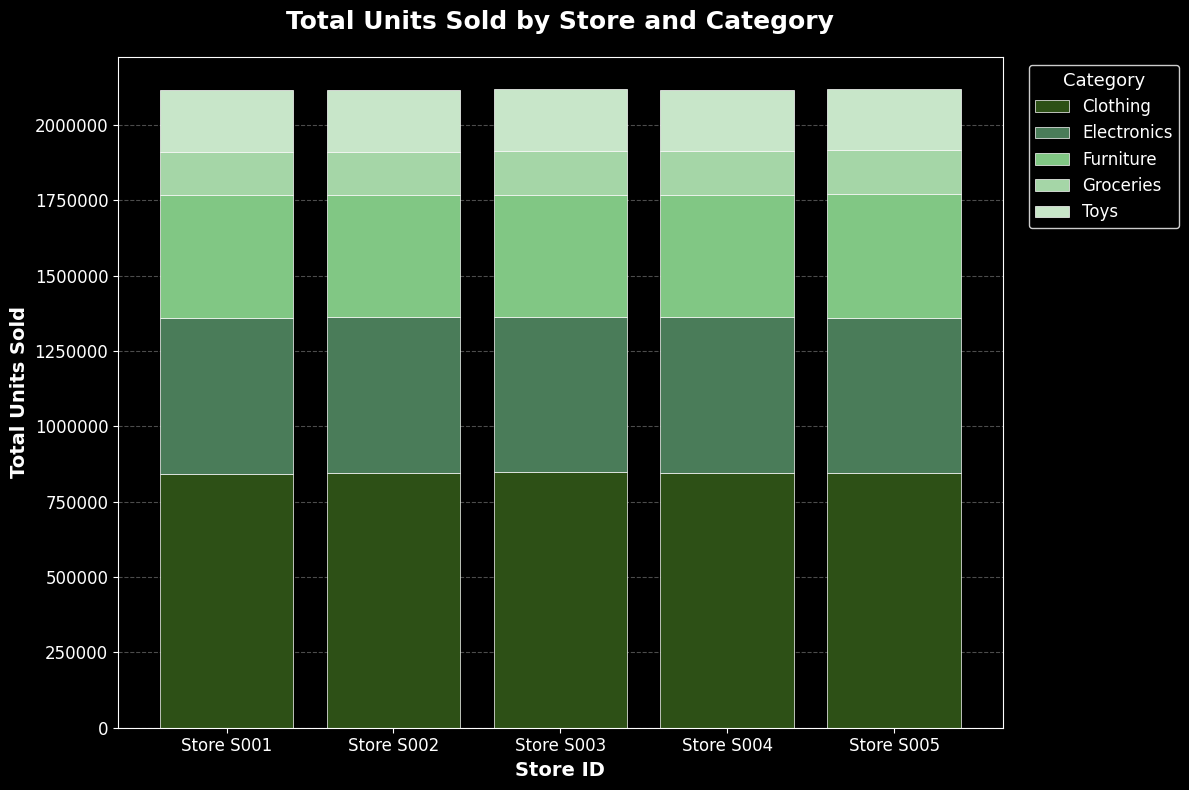

📊 Pivoted Sales Data by Store and Category:


Category,Clothing,Electronics,Furniture,Groceries,Toys
Store_ID,,,,,
S001,843207,515983,408482,144565,203061
S002,844675,517123,405395,144953,204483
S003,850146,513671,405699,146239,204404
S004,847105,515605,406042,146460,203066
S005,845747,514661,409733,147333,203479


In [15]:
# =============================================================================
# QUERY 3E: SALES VOLUME ACROSS CATEGORIES
# =============================================================================

# SQL query to aggregate sales by store and category
query_category_sales = """
SELECT Store_ID, Category, SUM(Units_Sold) as Total_Units_Sold
FROM InventoryData
GROUP BY Store_ID, Category
ORDER BY Store_ID, Category;
"""

# Execute query and load into DataFrame
df_category_sales = pd.read_sql_query(query_category_sales, conn)

# Pivot the DataFrame for stacked bar chart plotting
df_pivot = df_category_sales.pivot(index='Store_ID', columns='Category', values='Total_Units_Sold')

# Create the stacked bar chart with improved styling to match reference
fig, ax = plt.subplots(figsize=(12, 8))

# Define custom green color palette similar to the reference chart
colors = ['#2d5016', '#4a7c59', '#81c784', '#a5d6a7', '#c8e6c9']

# Create stacked bar chart
df_pivot.plot(kind='bar', stacked=True, ax=ax, color=colors[:len(df_pivot.columns)], 
              width=0.8, edgecolor='white', linewidth=0.5)

# Customize the plot to match reference appearance
ax.set_title('Total Units Sold by Store and Category', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Store ID', fontsize=14, fontweight='bold')
ax.set_ylabel('Total Units Sold', fontsize=14, fontweight='bold')

# Format x-axis
ax.set_xticks(range(len(df_pivot.index)))
ax.set_xticklabels([f'Store {store}' for store in df_pivot.index], rotation=0, fontsize=12)

# Format y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x)}'))
ax.tick_params(axis='y', labelsize=12)

# Customize legend
ax.legend(title='Category', bbox_to_anchor=(1.02, 1), loc='upper left', 
          fontsize=12, title_fontsize=13, frameon=True, fancybox=True, shadow=True)

# Add grid for better readability
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)


# Adjust layout
plt.tight_layout()
plt.show()

# Display the pivoted data
print("📊 Pivoted Sales Data by Store and Category:")
df_pivot

---

## 💰 PRICING & PROMOTION ANALYSIS

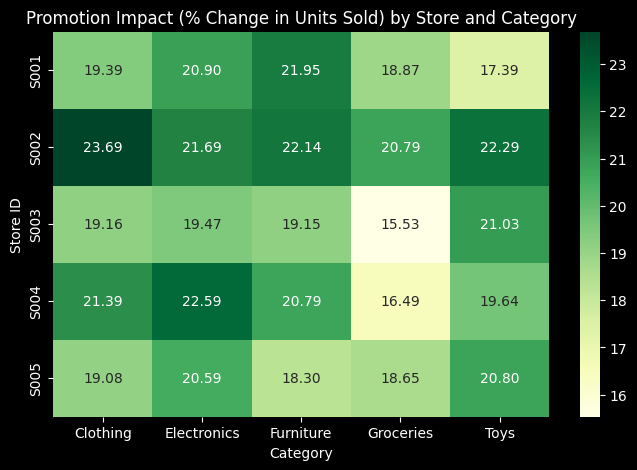

In [16]:
# =============================================================================
# QUERY 4A: HOLIDAY PROMOTION IMPACT ANALYSIS
# =============================================================================

query6 = """
SELECT Store_ID,Category,
       AVG(Units_Sold) AS Avg_Units_Sold,
       100*(AVG(CASE WHEN Holiday_Promotion = 1 THEN units_sold END)-
       AVG(CASE WHEN Holiday_Promotion = 0 THEN units_sold END))/ AVG(CASE WHEN Holiday_Promotion = 0 THEN units_sold END) AS Percentage_Change_Between_Promotions
FROM InventoryData
GROUP BY Store_ID,Category 
ORDER BY Percentage_Change_Between_Promotions DESC;
"""
df_kpi_by_promotions = pd.read_sql_query(query6, conn)
df_kpi_by_promotions_cat = df_kpi_by_promotions.pivot(index='Store_ID', columns='Category', values='Percentage_Change_Between_Promotions')
plt.figure(figsize=(8, 5))
sns.heatmap(df_kpi_by_promotions_cat, annot=True, fmt=".2f", cmap="YlGn")
plt.title("Promotion Impact (% Change in Units Sold) by Store and Category")
plt.ylabel("Store ID")
plt.xlabel("Category")
plt.show()

💰 Price Competitiveness vs Sales Performance:
📊 Products analyzed: 30


C:\Users\dsain\AppData\Local\Temp\ipykernel_23144\2793904285.py:29: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\MY FILES\Coding\SQL\proj\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


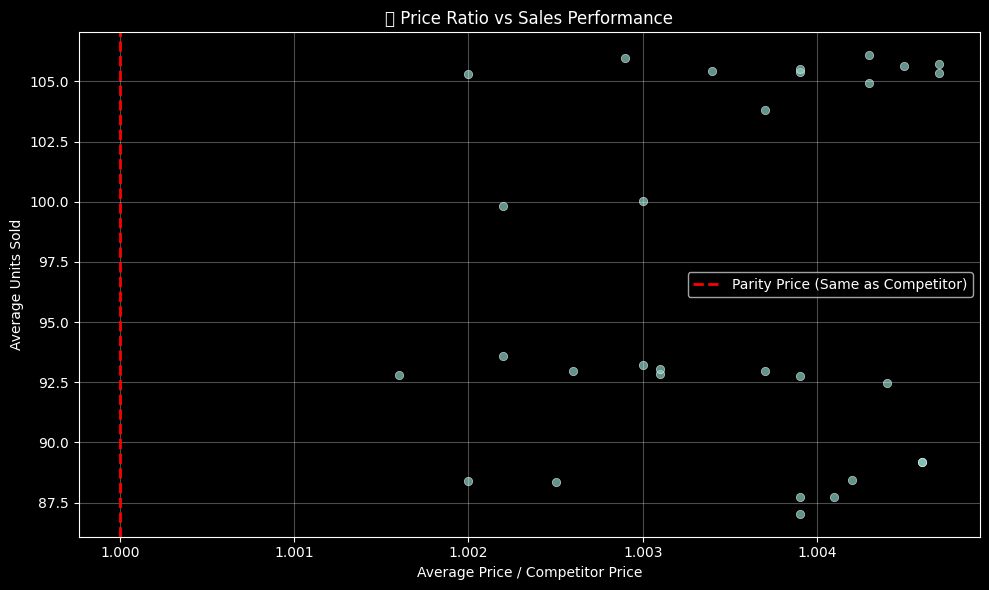

📋 Price-sales relationship data:


,Product_ID,Avg_Price_Ratio,Avg_Units_Sold,Observations
0,P0016,1.0047,105.344932,3650
1,P0017,1.0022,93.600000,3650
2,P0031,1.0042,88.423562,3650
3,P0046,1.0029,105.973973,3650
4,P0057,1.0043,106.084658,3650
5,P0061,1.0039,105.388493,3650
6,P0066,1.0034,105.414795,3650
7,P0067,1.0030,93.234521,3650
8,P0068,1.0039,87.032329,3650
9,P0069,1.0043,104.922740,3650


In [17]:
# =============================================================================
# QUERY 4B: PRICE COMPETITIVENESS VS SALES ANALYSIS
# =============================================================================

# Analyze correlation between pricing relative to competitors and sales performance
query7a = """
SELECT Product_ID,
       ROUND(AVG(Price / Competitor_Pricing), 4) AS Avg_Price_Ratio,
       AVG(Units_Sold) AS Avg_Units_Sold,
       COUNT(*) AS Observations
FROM InventoryData
WHERE Competitor_Pricing > 0
GROUP BY Product_ID;
"""

print("💰 Price Competitiveness vs Sales Performance:")
df_price_effect = pd.read_sql_query(query7a, conn)
print(f"📊 Products analyzed: {len(df_price_effect)}")

# Create scatter plot visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_price_effect, x='Avg_Price_Ratio', y='Avg_Units_Sold', alpha=0.7)
plt.axvline(1, color='red', linestyle='--', linewidth=2, label='Parity Price (Same as Competitor)')
plt.title('💰 Price Ratio vs Sales Performance')
plt.xlabel('Average Price / Competitor Price')
plt.ylabel('Average Units Sold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📋 Price-sales relationship data:")
df_price_effect

All products are priced above competitor levels.This may explain suboptimal sales performance for some SKUs.We reccomend dynamic pricing analysis.

In [18]:
# =============================================================================
# QUERY 4C: PRICE POSITIONING BUCKET ANALYSIS
# =============================================================================

# Categorize products into price positioning buckets and analyze performance
query7b = """
WITH ProductRatios AS (
  SELECT 
    Product_ID,
    ROUND(AVG(Price / Competitor_Pricing), 2) AS Avg_Price_Ratio,
    AVG(Units_Sold) AS Avg_Units_Sold
  FROM InventoryData
  WHERE Competitor_Pricing > 0
  GROUP BY Product_ID
)

SELECT
  CASE 
    WHEN Avg_Price_Ratio BETWEEN 1.00 AND 1.05 THEN '🟢 Slightly Higher (≤5%)'
    WHEN Avg_Price_Ratio BETWEEN 1.05 AND 1.20 THEN '🟡 Moderately Higher (5–20%)'
    ELSE '🔴 Significantly Higher (>20%)'
  END AS Price_Positioning,

  COUNT(*) AS Num_Products,
  ROUND(AVG(Avg_Units_Sold), 2) AS Avg_Units_Sold

FROM ProductRatios
GROUP BY Price_Positioning
ORDER BY Price_Positioning;
"""

print("📊 Price Positioning Bucket Analysis:")
result_price_buckets = pd.read_sql_query(query7b, conn)
print("💡 Products categorized by competitive pricing:")
result_price_buckets

📊 Price Positioning Bucket Analysis:
💡 Products categorized by competitive pricing:


,Price_Positioning,Num_Products,Avg_Units_Sold
0,🟢 Slightly Higher (≤5%),30,96.72


In [53]:
# =============================================================================
# QUERY 5A: FORECAST ACCURACY BY PRODUCT
# =============================================================================

# Calculate forecast accuracy metrics for each product
query8 = """
SELECT Product_ID,
       100*ROUND(AVG(ABS(Units_Sold - Demand_Forecast)/Units_Sold), 4) AS Avg_Forecast_Error
FROM InventoryData
GROUP BY Product_ID
ORDER BY Avg_Forecast_Error DESC;
"""

print("🎯 Forecast Accuracy Analysis by Product:")
result_forecast_accuracy = pd.read_sql_query(query8, conn)
print(f"📊 Products evaluated: {len(result_forecast_accuracy)}")
print(f"📈 Average forecast error across all products: {result_forecast_accuracy['Avg_Forecast_Error'].mean():.2f}%")
print("⚠️ Products with highest forecast errors:")
result_forecast_accuracy

🎯 Forecast Accuracy Analysis by Product:
📊 Products evaluated: 30
📈 Average forecast error across all products: 15.82%
⚠️ Products with highest forecast errors:


,Product_ID,Avg_Forecast_Error
0,P0079,16.15
1,P0031,16.13
2,P0085,16.09
3,P0187,16.08
4,P0183,15.99
5,P0094,15.95
6,P0046,15.95
7,P0069,15.94
8,P0017,15.93
9,P0149,15.90


---

## 🎯 FORECAST ACCURACY EVALUATION

**Python** **Forecasting**

---

## 🤖 MACHINE LEARNING FORECASTING

Advanced inventory forecasting using **Prophet** (time series) and **Random Forest** (machine learning) models.


Import libraries needed for forecasting

### 📚 Machine Learning Libraries

We'll use **Prophet** for time series forecasting, **Random Forest** for feature-based machine learning, and **pandas** for data manipulation.

In [20]:
# =============================================================================
# QUERY 6A: TOP PRODUCTS SELECTION FOR ML FORECASTING
# =============================================================================

# Select top 5 products by total sales volume for ML forecasting pipeline
query_top_products = """
SELECT Product_ID, 
SUM(Units_Sold) AS Total_Units,
       COUNT(DISTINCT Date) AS Days_Tracked,
       AVG(Units_Sold) AS Avg_Daily_Sales
FROM InventoryData
GROUP BY Product_ID
ORDER BY Total_Units DESC
LIMIT 5;
"""

print("🏆 Top 5 Products for ML Forecasting:")
top_products_data = pd.read_sql_query(query_top_products, conn)
top_products = top_products_data['Product_ID'].tolist()

print(f"Selected products: {top_products}")
print("📊 Product performance summary:")
print(top_products_data)
top_products

🏆 Top 5 Products for ML Forecasting:
Selected products: ['P0057', 'P0046', 'P0133', 'P0187', 'P0125']
📊 Product performance summary:
  Product_ID  Total_Units  Days_Tracked  Avg_Daily_Sales
0      P0057       387209           730       106.084658
1      P0046       386805           730       105.973973
2      P0133       385843           730       105.710411
3      P0187       385583           730       105.639178
4      P0125       385137           730       105.516986


['P0057', 'P0046', 'P0133', 'P0187', 'P0125']

In [21]:
# =============================================================================
# ML FORECASTING FUNCTION - HYBRID PROPHET + RANDOM FOREST
# =============================================================================

def forecast_for_product(product_id, conn):
    """
        Advanced ML forecasting function combining Prophet (time series) and Random Forest.
        
        Args:
            product_id (str): Product ID to forecast
            conn: Database connection
            
        Returns:
            DataFrame with blended forecasts and reorder recommendations
    """
    
    # 1. Load historical data for the product
    query = f"""
    SELECT Date, Product_ID, Units_Sold, Demand_Forecast, Price, Competitor_Pricing,
           Discount, Holiday_Promotion, Inventory_Level
    FROM InventoryData
    WHERE Product_ID = '{product_id}'
    ORDER BY Date;
    """
    df = pd.read_sql_query(query, conn)

    # Data quality check
    if len(df) < 30:
        print(f"⚠️ Insufficient data for {product_id}: {len(df)} records")
        return None

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    # 2. Feature engineering for Random Forest
    print(f"🔧 Engineering features for {product_id}...")
    df['Lag_1'] = df['Units_Sold'].shift(1)  # Previous day sales
    df['Lag_7'] = df['Units_Sold'].shift(7)  # Weekly pattern
    df['Rolling_7'] = df['Units_Sold'].rolling(7).mean()  # 7-day moving average
    df['Price_Ratio'] = df['Price'] / df['Competitor_Pricing']  # Competitive positioning
    df['Promo_Flag'] = (df['Holiday_Promotion'] == 'Yes').astype(int)  # Promotion effect
    df = df.dropna()

    if df.shape[0] < 21:
        print(f"⚠️ Insufficient clean data for {product_id}: {df.shape[0]} records")
        return None

    # 3. Train Random Forest model
    print(f"🌳 Training Random Forest for {product_id}...")
    features = ['Lag_1', 'Lag_7', 'Rolling_7', 'Price_Ratio', 'Promo_Flag']
    X = df[features]
    y = df['Units_Sold']
    X_train, X_test = X[:-14], X[-14:]  # Use last 14 days for validation
    y_train = y[:-14]

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)

    # 4. Prophet time series model
    print(f"📈 Training Prophet time series for {product_id}...")
    df_prophet = df[['Date', 'Units_Sold']].rename(columns={'Date': 'ds', 'Units_Sold': 'y'})

    # Suppress Prophet verbose output
    import logging
    logging.getLogger('prophet').setLevel(logging.WARNING)
    
    prophet_model = Prophet(daily_seasonality=True, weekly_seasonality=True)
    prophet_model.fit(df_prophet)
    future = prophet_model.make_future_dataframe(periods=14)
    forecast = prophet_model.predict(future)
    prophet_pred = forecast[['ds', 'yhat']].tail(14).reset_index(drop=True)

    # 5. Blend
    blended_df = df[['Date']].iloc[-14:].reset_index(drop=True)
    blended_df['RF_Pred'] = rf_pred
    blended_df['Prophet_Pred'] = prophet_pred['yhat']
    blended_df['Blended_Forecast'] = 0.7 * rf_pred + 0.3 * prophet_pred['yhat']
    blended_df['Date'] = prophet_pred['ds']
    blended_df['Product_ID'] = product_id

    # 6. Reorder logic with safety stock
    print(f"📦 Calculating reorder quantities for {product_id}...")
    blended_df['Safety_Stock'] = 0.1 * blended_df['Blended_Forecast']  # 10% buffer
    blended_df['Required_Inventory'] = blended_df['Blended_Forecast'] + blended_df['Safety_Stock']
    current_inventory = df['Inventory_Level'].iloc[-1]
    blended_df['Reorder_Qty'] = (blended_df['Required_Inventory'] - current_inventory).clip(lower=0).round()

    return blended_df[['Product_ID', 'Date', 'Blended_Forecast', 'Reorder_Qty']]

print("✅ ML Forecasting function defined successfully!")


✅ ML Forecasting function defined successfully!


### 🔧 ML Forecasting Pipeline

**Hybrid Approach**: SQL → Feature Engineering → Random Forest + Prophet → Blended Forecasts → Reorder Recommendations

The function combines:
- **Feature Engineering**: Lag variables, moving averages, price ratios
- **Random Forest**: Captures complex patterns and feature interactions  
- **Prophet**: Handles seasonality and trends
- **Ensemble**: 70% RF + 30% Prophet for robust predictions


In [22]:
# =============================================================================
# QUERY 6B: EXECUTE ML FORECASTING FOR TOP PRODUCTS
# =============================================================================

# Run ML forecasting pipeline for each of the top 5 products
print("🚀 Starting ML Forecasting Pipeline...")
print("="*60)

all_forecasts = []
total_products = len(top_products)

for i, pid in enumerate(top_products, 1):
    print(f"📊 Processing {pid} ({i}/{total_products})...")
    result = forecast_for_product(pid, conn)
    if result is not None:
        all_forecasts.append(result)
        print(f"✅ {pid} completed successfully!")
    else:
        print(f"❌ {pid} failed - insufficient data")
    print("-" * 40)

# Combine all forecasting results
if all_forecasts:
    forecast_results = pd.concat(all_forecasts, ignore_index=True)
    forecast_results.head()

🚀 Starting ML Forecasting Pipeline...
📊 Processing P0057 (1/5)...
🔧 Engineering features for P0057...
🌳 Training Random Forest for P0057...


18:25:35 - cmdstanpy - INFO - Chain [1] start processing


📈 Training Prophet time series for P0057...


18:25:36 - cmdstanpy - INFO - Chain [1] done processing


📦 Calculating reorder quantities for P0057...
✅ P0057 completed successfully!
----------------------------------------
📊 Processing P0046 (2/5)...
🔧 Engineering features for P0046...
🌳 Training Random Forest for P0046...


18:25:37 - cmdstanpy - INFO - Chain [1] start processing


📈 Training Prophet time series for P0046...


18:25:37 - cmdstanpy - INFO - Chain [1] done processing


📦 Calculating reorder quantities for P0046...
✅ P0046 completed successfully!
----------------------------------------
📊 Processing P0133 (3/5)...
🔧 Engineering features for P0133...
🌳 Training Random Forest for P0133...


18:25:38 - cmdstanpy - INFO - Chain [1] start processing


📈 Training Prophet time series for P0133...


18:25:39 - cmdstanpy - INFO - Chain [1] done processing


📦 Calculating reorder quantities for P0133...
✅ P0133 completed successfully!
----------------------------------------
📊 Processing P0187 (4/5)...
🔧 Engineering features for P0187...
🌳 Training Random Forest for P0187...


18:25:40 - cmdstanpy - INFO - Chain [1] start processing


📈 Training Prophet time series for P0187...


18:25:40 - cmdstanpy - INFO - Chain [1] done processing


📦 Calculating reorder quantities for P0187...
✅ P0187 completed successfully!
----------------------------------------
📊 Processing P0125 (5/5)...
🔧 Engineering features for P0125...
🌳 Training Random Forest for P0125...


18:25:41 - cmdstanpy - INFO - Chain [1] start processing


📈 Training Prophet time series for P0125...


18:25:42 - cmdstanpy - INFO - Chain [1] done processing


📦 Calculating reorder quantities for P0125...
✅ P0125 completed successfully!
----------------------------------------


# 📊 COMPREHENSIVE BUSINESS INTELLIGENCE DASHBOARD

This section consolidates all SQL queries into properly named dataframes with interactive visualizations and actionable business insights.

📋 Categories in Dataset:
      Category
0         Toys
1     Clothing
2  Electronics
3    Furniture
4    Groceries

📊 Total Category-Product Combinations: 30


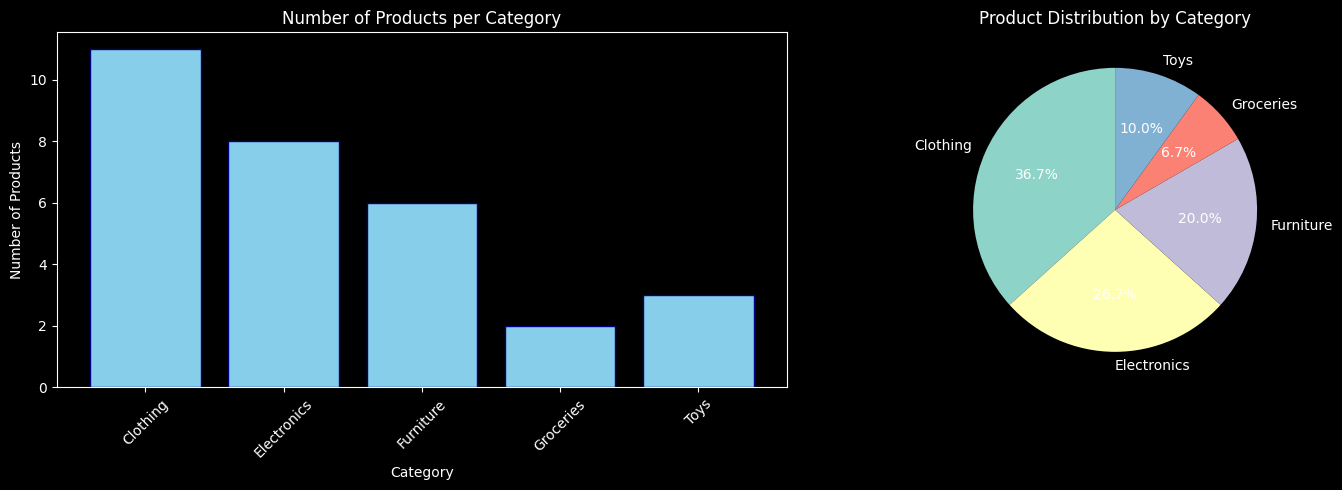

In [23]:
# =====================================
# 1. BASIC DATA EXPLORATION QUERIES
# =====================================

# Query 1A: Distinct Categories
df_distinct_categories = pd.read_sql_query("""
SELECT DISTINCT Category FROM InventoryData
""", conn)

# Query 1B: Distinct Category-Product combinations
df_category_products = pd.read_sql_query("""
SELECT DISTINCT Category, Product_ID
FROM InventoryData
ORDER BY Category, Product_ID
""", conn)

print("📋 Categories in Dataset:")
print(df_distinct_categories)
print(f"\n📊 Total Category-Product Combinations: {len(df_category_products)}")

# Visualization: Product count by category
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Chart 1: Products per category
category_counts = df_category_products.groupby('Category').size()
ax1.bar(category_counts.index, category_counts.values, color='skyblue', edgecolor='navy')
ax1.set_title('Number of Products per Category')
ax1.set_xlabel('Category')
ax1.set_ylabel('Number of Products')
ax1.tick_params(axis='x', rotation=45)

# Chart 2: Pie chart of category distribution
ax2.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('Product Distribution by Category')

plt.tight_layout()
plt.show()

✅ Store KPIs by Category: df_kpi_by_store
Shape: (5, 16)
✅ Product KPIs: df_kpi_by_product
Shape: (150, 5)
✅ Anomalous Products (>2% deviation): df_kpi_anom_2per
Shape: (0, 5)


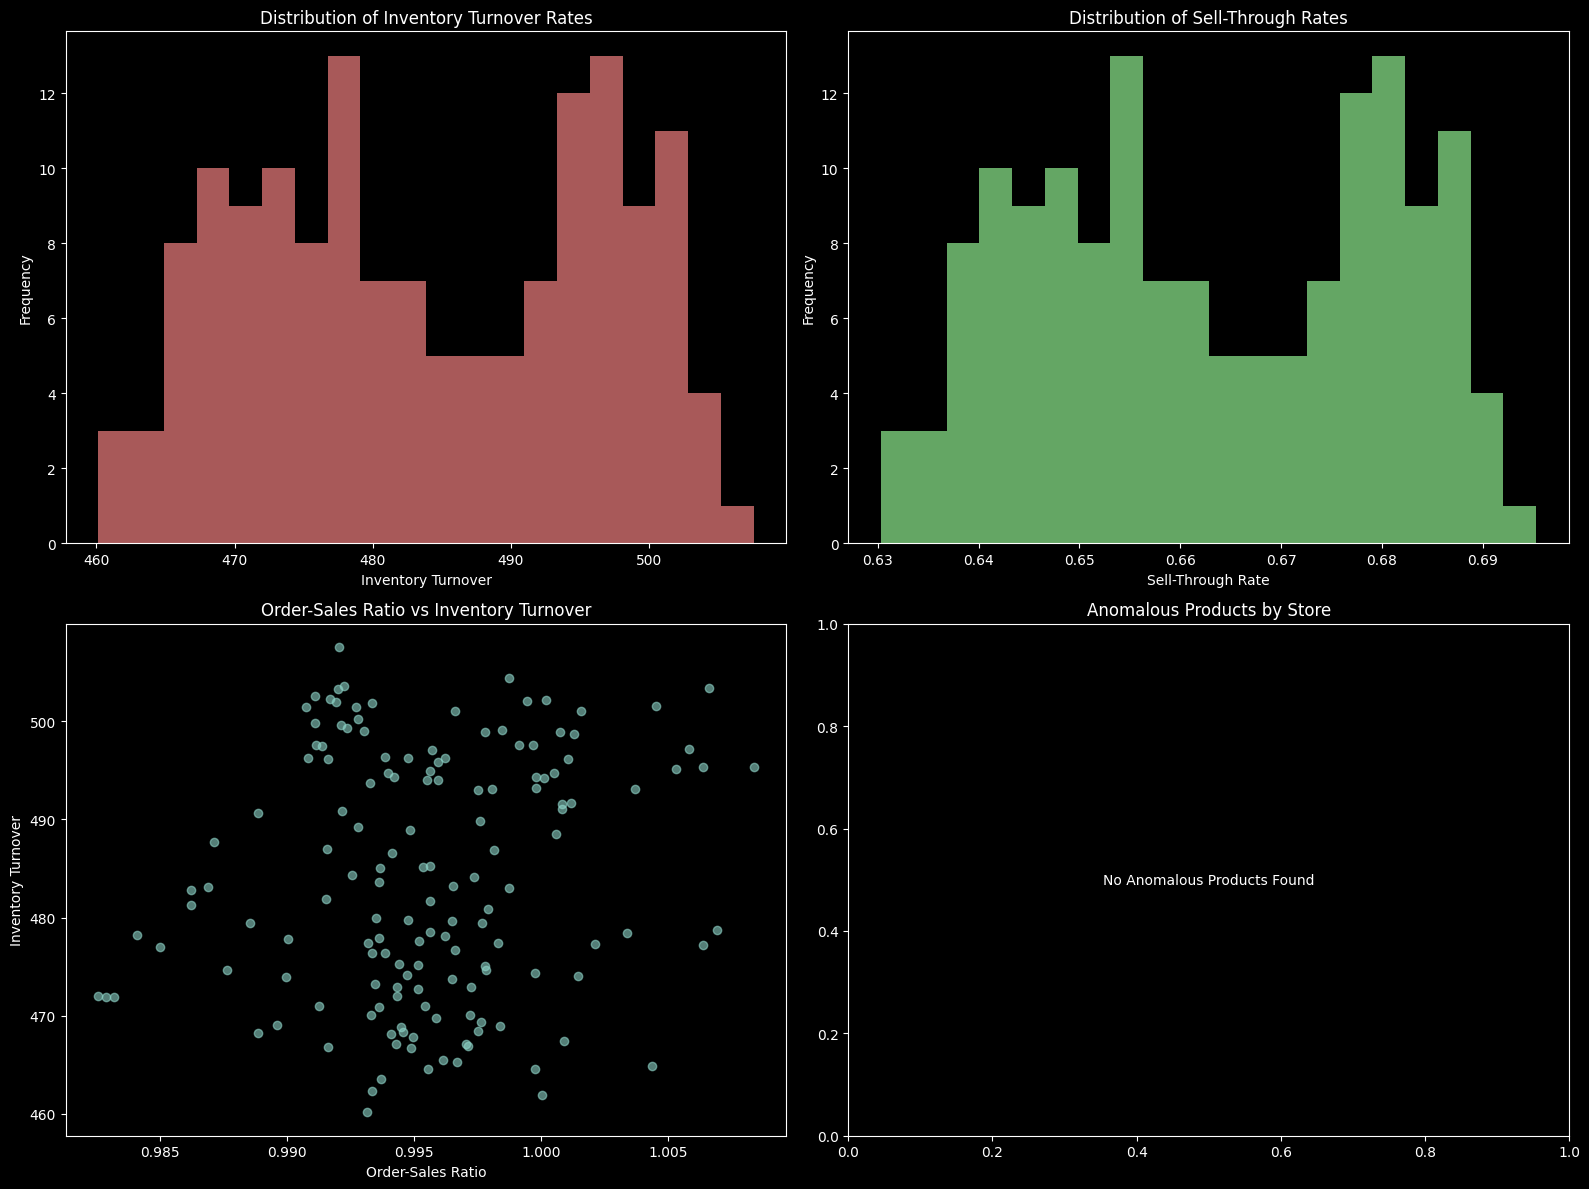

In [24]:
# =====================================
# 2. KPI ANALYSIS QUERIES
# =====================================

# Query 2A: Store-level KPIs by Category (already exists as df_kpi_by_store)
print("✅ Store KPIs by Category: df_kpi_by_store")
print(f"Shape: {df_kpi_by_store.shape}")

# Query 2B: Product-level KPIs (already exists as df_kpi_by_product)  
print("✅ Product KPIs: df_kpi_by_product")
print(f"Shape: {df_kpi_by_product.shape}")

# Query 2C: Anomalous Order-Sales Ratios (already exists as df_kpi_anom_2per)
print("✅ Anomalous Products (>2% deviation): df_kpi_anom_2per")
print(f"Shape: {df_kpi_anom_2per.shape}")

# Additional KPI Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Chart 1: Inventory Turnover Distribution
axes[0,0].hist(df_kpi_by_product['Inventory_Turnover'].dropna(), bins=20, color='lightcoral', alpha=0.7)
axes[0,0].set_title('Distribution of Inventory Turnover Rates')
axes[0,0].set_xlabel('Inventory Turnover')
axes[0,0].set_ylabel('Frequency')

# Chart 2: Sell-Through Rate Distribution
axes[0,1].hist(df_kpi_by_product['Sell_Through_Rate'].dropna(), bins=20, color='lightgreen', alpha=0.7)
axes[0,1].set_title('Distribution of Sell-Through Rates')
axes[0,1].set_xlabel('Sell-Through Rate')
axes[0,1].set_ylabel('Frequency')

# Chart 3: Order-Sales Ratio vs Inventory Turnover
scatter_data = df_kpi_by_product.dropna()
axes[1,0].scatter(scatter_data['Order_Sales_Ratio'], scatter_data['Inventory_Turnover'], alpha=0.6)
axes[1,0].set_title('Order-Sales Ratio vs Inventory Turnover')
axes[1,0].set_xlabel('Order-Sales Ratio')
axes[1,0].set_ylabel('Inventory Turnover')

# Chart 4: Anomalous products by store
if len(df_kpi_anom_2per) > 0:
    anom_by_store = df_kpi_anom_2per.groupby('Store_ID').size()
    axes[1,1].bar(anom_by_store.index, anom_by_store.values, color='orange')
    axes[1,1].set_title('Anomalous Products by Store')
    axes[1,1].set_xlabel('Store ID')
    axes[1,1].set_ylabel('Number of Anomalous Products')
else:
    axes[1,1].text(0.5, 0.5, 'No Anomalous Products Found', ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Anomalous Products by Store')

plt.tight_layout()
plt.show()

📦 Current Stock Levels: 150 records
🚨 Low Inventory Alerts: 16272 alerts
📈 7-Day Rolling Sales: 30 products
🔄 Inventory Turnover: 30 products
📊 Daily Sales Stats: 30 products


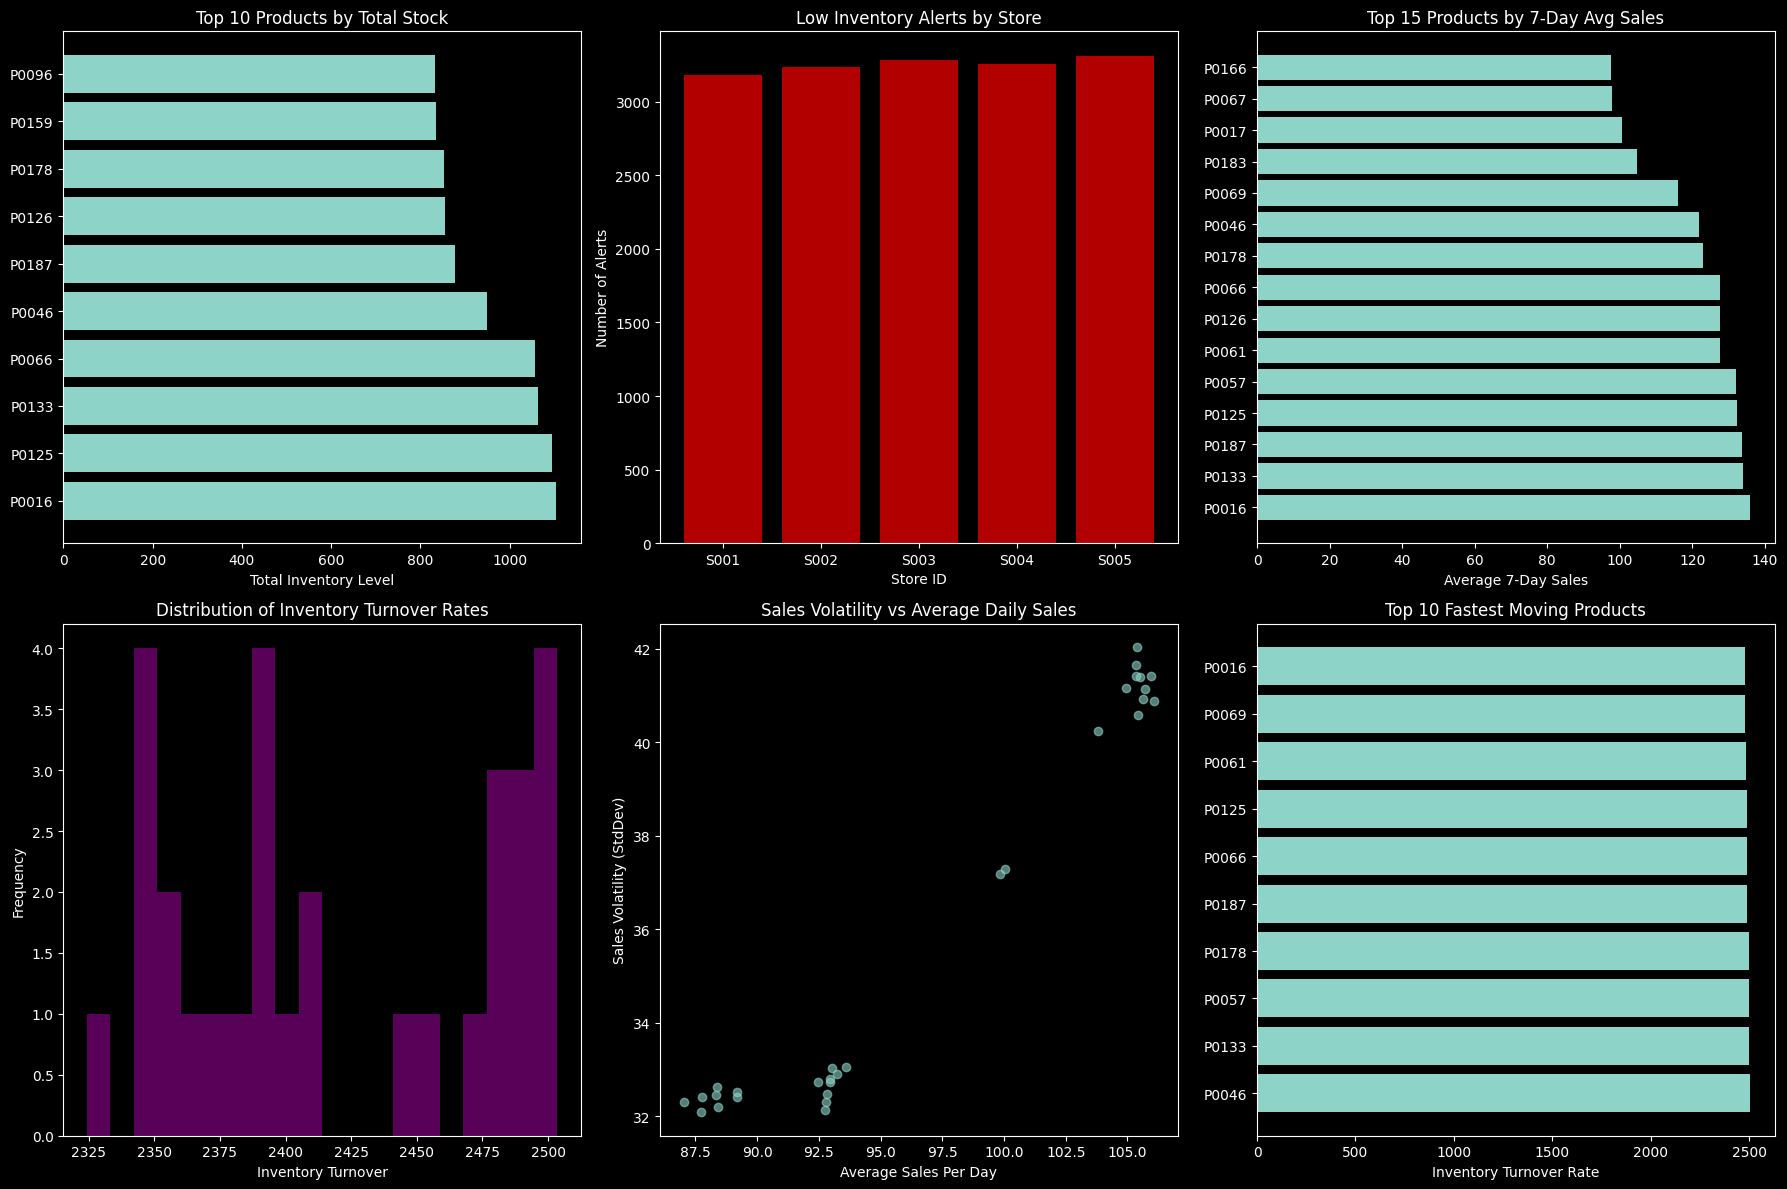

In [25]:
# =====================================
# 3. INVENTORY MANAGEMENT QUERIES
# =====================================

# Query 3A: Current Stock Levels by Store and Product
df_current_stock = pd.read_sql_query("""
SELECT Product_ID, Store_ID, Inventory_Level
FROM InventoryData
WHERE Date = (SELECT MAX(Date) FROM InventoryData)
ORDER BY Product_ID, Store_ID;
""", conn)

# Query 3B: Low Inventory Alerts 
df_low_inventory_alerts = pd.read_sql_query("""
SELECT Date, Product_ID, Store_ID, Inventory_Level, Demand_Forecast,
       (Demand_Forecast - Inventory_Level) AS Shortage_Amount
FROM InventoryData
WHERE Inventory_Level < Demand_Forecast
ORDER BY Date, Shortage_Amount DESC;
""", conn)

# Query 3C: 7-Day Rolling Sales Average
df_rolling_sales_7day = pd.read_sql_query("""
SELECT Product_ID,
       ROUND(AVG(Units_Sold),2) AS Avg_7Day_Sales,
       COUNT(*) AS Days_In_Period
FROM InventoryData
WHERE Date >= (
   SELECT DATE(MAX(Date), '-6 day')
   FROM InventoryData
)
GROUP BY Product_ID
ORDER BY Avg_7Day_Sales DESC;
""", conn)

# Query 3D: Inventory Turnover Analysis
df_inventory_turnover = pd.read_sql_query("""
SELECT Product_ID,
       SUM(Units_Sold) as Total_Sales,
       AVG(Inventory_Level) as Avg_Inventory,
       ROUND(SUM(Units_Sold)/AVG(Inventory_Level),2) AS Inventory_Turnover,
       COUNT(DISTINCT Date) AS Days_Tracked
FROM InventoryData
GROUP BY Product_ID
ORDER BY Inventory_Turnover DESC;
""", conn)

# Query 3E: Average Daily Sales Volume by Product
df_avg_daily_sales = pd.read_sql_query("""
SELECT Product_ID,
       ROUND(AVG(Units_Sold),2) AS Avg_Sales_Per_Day,
       MIN(Units_Sold) AS Min_Daily_Sales,
       MAX(Units_Sold) AS Max_Daily_Sales,
       COUNT(*) AS Total_Days
FROM InventoryData
GROUP BY Product_ID
ORDER BY Avg_Sales_Per_Day DESC;
""", conn)

# Calculate sales volatility using pandas
df_volatility = pd.read_sql_query("""
SELECT Product_ID, Units_Sold 
FROM InventoryData
""", conn).groupby('Product_ID')['Units_Sold'].std().reset_index()
df_volatility.columns = ['Product_ID', 'Sales_Volatility']
df_volatility['Sales_Volatility'] = df_volatility['Sales_Volatility'].round(2)

# Merge volatility with main dataframe
df_avg_daily_sales = df_avg_daily_sales.merge(df_volatility, on='Product_ID', how='left')

print(f"📦 Current Stock Levels: {len(df_current_stock)} records")
print(f"🚨 Low Inventory Alerts: {len(df_low_inventory_alerts)} alerts")
print(f"📈 7-Day Rolling Sales: {len(df_rolling_sales_7day)} products")
print(f"🔄 Inventory Turnover: {len(df_inventory_turnover)} products")
print(f"📊 Daily Sales Stats: {len(df_avg_daily_sales)} products")

# Inventory Management Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Chart 1: Top 10 products by current stock
top_stock = df_current_stock.groupby('Product_ID')['Inventory_Level'].sum().nlargest(10)
axes[0,0].barh(range(len(top_stock)), top_stock.values)
axes[0,0].set_yticks(range(len(top_stock)))
axes[0,0].set_yticklabels(top_stock.index)
axes[0,0].set_title('Top 10 Products by Total Stock')
axes[0,0].set_xlabel('Total Inventory Level')

# Chart 2: Low inventory distribution by store
if len(df_low_inventory_alerts) > 0:
    low_inv_by_store = df_low_inventory_alerts.groupby('Store_ID').size()
    axes[0,1].bar(low_inv_by_store.index, low_inv_by_store.values, color='red', alpha=0.7)
    axes[0,1].set_title('Low Inventory Alerts by Store')
    axes[0,1].set_xlabel('Store ID')
    axes[0,1].set_ylabel('Number of Alerts')
else:
    axes[0,1].text(0.5, 0.5, 'No Low Inventory Alerts', ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('Low Inventory Alerts by Store')

# Chart 3: Top 15 products by 7-day rolling sales
top_rolling = df_rolling_sales_7day.head(15)
axes[0,2].barh(range(len(top_rolling)), top_rolling['Avg_7Day_Sales'])
axes[0,2].set_yticks(range(len(top_rolling)))
axes[0,2].set_yticklabels(top_rolling['Product_ID'])
axes[0,2].set_title('Top 15 Products by 7-Day Avg Sales')
axes[0,2].set_xlabel('Average 7-Day Sales')

# Chart 4: Inventory turnover distribution
axes[1,0].hist(df_inventory_turnover['Inventory_Turnover'].dropna(), bins=20, color='purple', alpha=0.7)
axes[1,0].set_title('Distribution of Inventory Turnover Rates')
axes[1,0].set_xlabel('Inventory Turnover')
axes[1,0].set_ylabel('Frequency')

# Chart 5: Sales volatility vs average sales
axes[1,1].scatter(df_avg_daily_sales['Avg_Sales_Per_Day'], df_avg_daily_sales['Sales_Volatility'], alpha=0.6)
axes[1,1].set_title('Sales Volatility vs Average Daily Sales')
axes[1,1].set_xlabel('Average Sales Per Day')
axes[1,1].set_ylabel('Sales Volatility (StdDev)')

# Chart 6: Top 10 fastest moving products
top_turnover = df_inventory_turnover.head(10)
axes[1,2].barh(range(len(top_turnover)), top_turnover['Inventory_Turnover'])
axes[1,2].set_yticks(range(len(top_turnover)))
axes[1,2].set_yticklabels(top_turnover['Product_ID'])
axes[1,2].set_title('Top 10 Fastest Moving Products')
axes[1,2].set_xlabel('Inventory Turnover Rate')

plt.tight_layout()
plt.show()

✅ Promotion Impact by Store & Category: df_kpi_by_promotions
Shape: (25, 4)
✅ Price Competitiveness vs Sales: df_price_effect
Shape: (30, 4)
💰 Price Positioning Analysis: 30 products
🎯 Promotion Performance Details: 150 product-store combinations


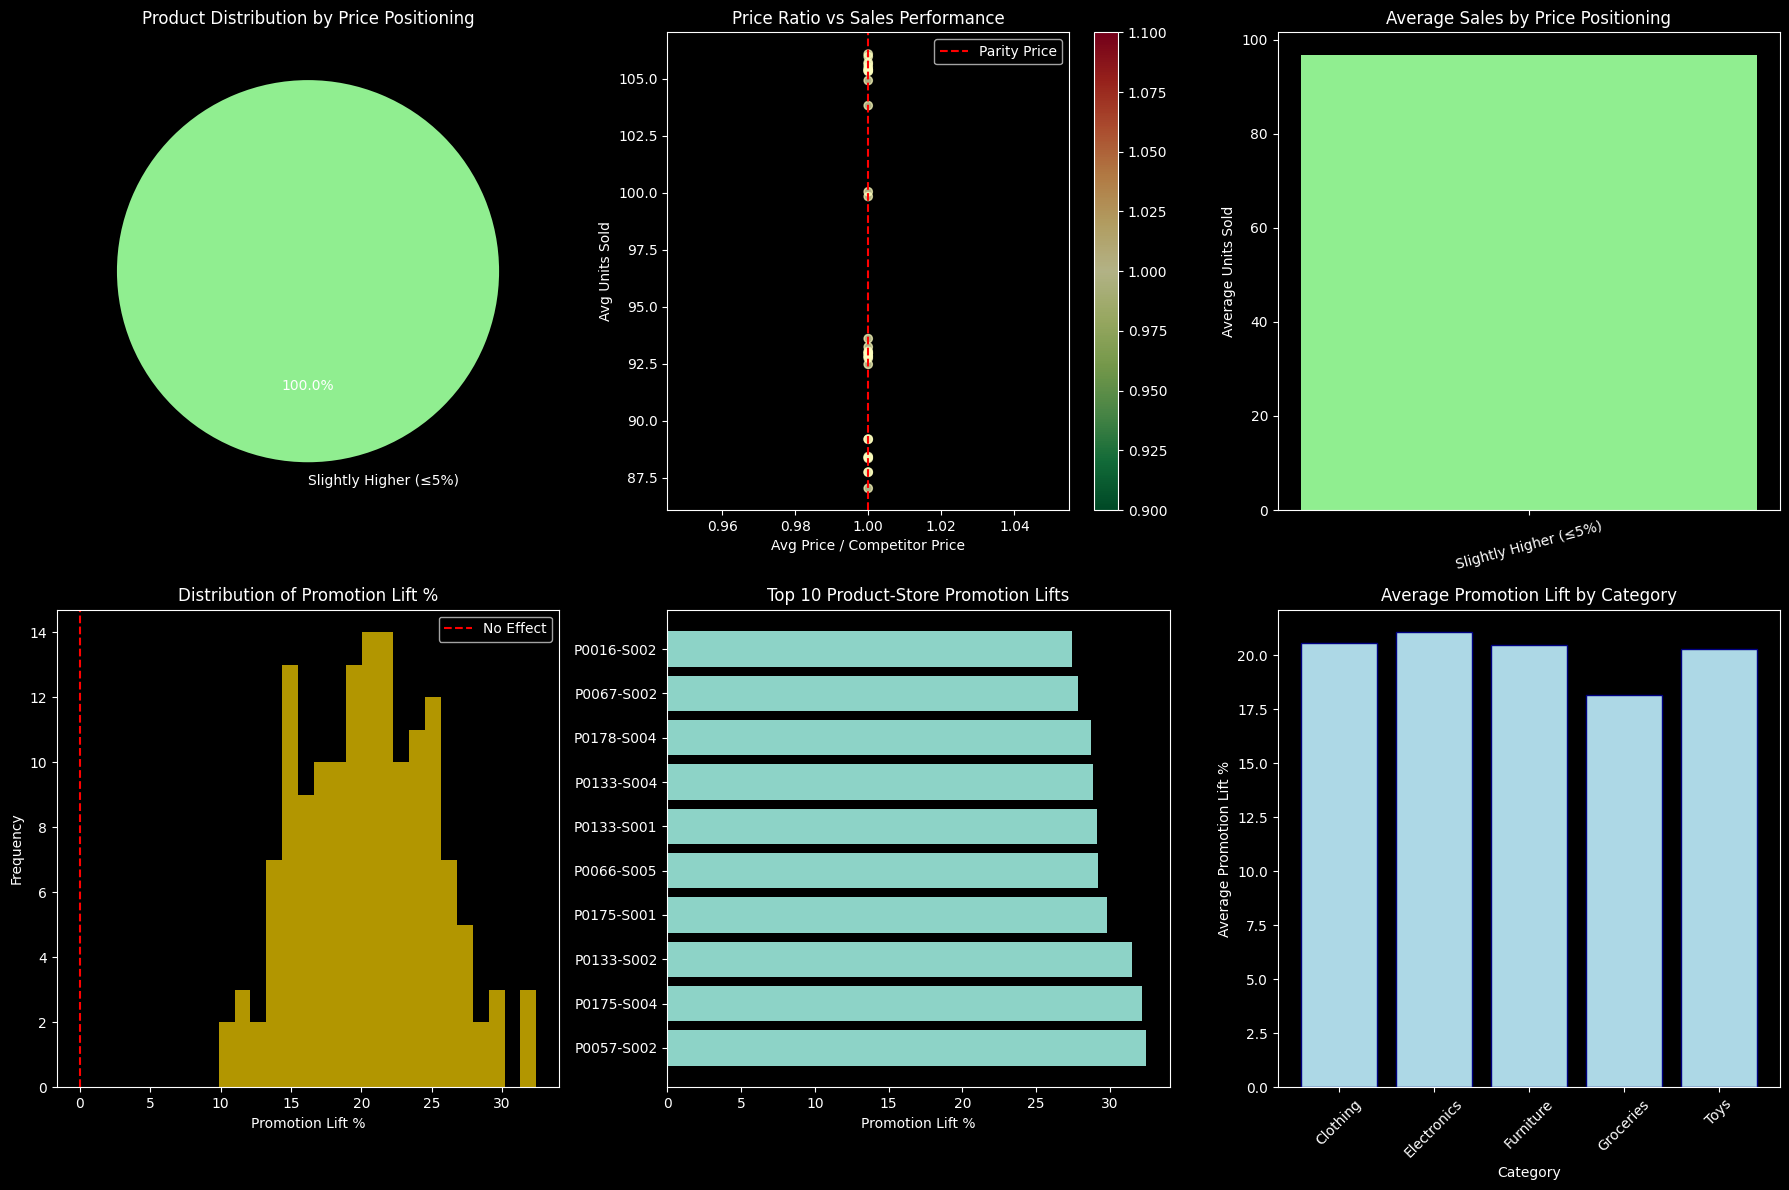

In [26]:
# =====================================
# 4. PRICING & PROMOTION ANALYSIS
# =====================================

# Query 4A: Promotion Impact Analysis (already exists as df_kpi_by_promotions)
print("✅ Promotion Impact by Store & Category: df_kpi_by_promotions")
print(f"Shape: {df_kpi_by_promotions.shape}")

# Query 4B: Price Competitiveness Analysis (already exists as df_price_effect)
print("✅ Price Competitiveness vs Sales: df_price_effect") 
print(f"Shape: {df_price_effect.shape}")

# Query 4C: Price Positioning Buckets
df_price_positioning = pd.read_sql_query("""
WITH ProductRatios AS (
  SELECT 
    Product_ID,
    ROUND(AVG(Price / Competitor_Pricing), 2) AS Avg_Price_Ratio,
    AVG(Units_Sold) AS Avg_Units_Sold,
    COUNT(*) AS Observation_Count
  FROM InventoryData
  WHERE Competitor_Pricing > 0
  GROUP BY Product_ID
)

SELECT
  Product_ID,
  Avg_Price_Ratio,
  Avg_Units_Sold,
  Observation_Count,
  CASE 
    WHEN Avg_Price_Ratio BETWEEN 1.00 AND 1.05 THEN 'Slightly Higher (≤5%)'
    WHEN Avg_Price_Ratio BETWEEN 1.05 AND 1.20 THEN 'Moderately Higher (5–20%)'
    ELSE 'Significantly Higher (>20%)'
  END AS Price_Positioning

FROM ProductRatios
ORDER BY Avg_Price_Ratio;
""", conn)

# Query 4D: Detailed Promotion Performance
df_promotion_details = pd.read_sql_query("""
SELECT 
    Product_ID,
    Category,
    Store_ID,
    AVG(CASE WHEN Holiday_Promotion = 1 THEN Units_Sold END) AS Promo_Avg_Sales,
    AVG(CASE WHEN Holiday_Promotion = 0 THEN Units_Sold END) AS Regular_Avg_Sales,
    COUNT(CASE WHEN Holiday_Promotion = 1 THEN 1 END) AS Promo_Days,
    COUNT(CASE WHEN Holiday_Promotion = 0 THEN 1 END) AS Regular_Days,
    100 * (AVG(CASE WHEN Holiday_Promotion = 1 THEN Units_Sold END) - 
           AVG(CASE WHEN Holiday_Promotion = 0 THEN Units_Sold END)) / 
           NULLIF(AVG(CASE WHEN Holiday_Promotion = 0 THEN Units_Sold END), 0) AS Promo_Lift_Percent
FROM InventoryData
GROUP BY Product_ID, Category, Store_ID
HAVING Promo_Days > 0 AND Regular_Days > 0
ORDER BY Promo_Lift_Percent DESC;
""", conn)

print(f"💰 Price Positioning Analysis: {len(df_price_positioning)} products")
print(f"🎯 Promotion Performance Details: {len(df_promotion_details)} product-store combinations")

# Pricing & Promotion Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Chart 1: Price positioning distribution
price_bucket_counts = df_price_positioning['Price_Positioning'].value_counts()
colors = ['lightgreen', 'orange', 'red']
axes[0,0].pie(price_bucket_counts.values, labels=price_bucket_counts.index, autopct='%1.1f%%', 
              colors=colors, startangle=90)
axes[0,0].set_title('Product Distribution by Price Positioning')

# Chart 2: Price ratio vs sales (enhanced)
scatter = axes[0,1].scatter(df_price_positioning['Avg_Price_Ratio'], 
                           df_price_positioning['Avg_Units_Sold'], 
                           c=df_price_positioning['Avg_Price_Ratio'], 
                           cmap='RdYlGn_r', alpha=0.7)
axes[0,1].axvline(1, color='red', linestyle='--', label='Parity Price')
axes[0,1].set_title('Price Ratio vs Sales Performance')
axes[0,1].set_xlabel('Avg Price / Competitor Price')
axes[0,1].set_ylabel('Avg Units Sold')
axes[0,1].legend()
plt.colorbar(scatter, ax=axes[0,1])

# Chart 3: Average sales by price bucket
price_bucket_sales = df_price_positioning.groupby('Price_Positioning')['Avg_Units_Sold'].mean()
axes[0,2].bar(range(len(price_bucket_sales)), price_bucket_sales.values, color=colors)
axes[0,2].set_xticks(range(len(price_bucket_sales)))
axes[0,2].set_xticklabels(price_bucket_sales.index, rotation=15)
axes[0,2].set_title('Average Sales by Price Positioning')
axes[0,2].set_ylabel('Average Units Sold')

# Chart 4: Promotion lift distribution
axes[1,0].hist(df_promotion_details['Promo_Lift_Percent'].dropna(), bins=20, color='gold', alpha=0.7)
axes[1,0].set_title('Distribution of Promotion Lift %')
axes[1,0].set_xlabel('Promotion Lift %')
axes[1,0].set_ylabel('Frequency')
axes[1,0].axvline(0, color='red', linestyle='--', label='No Effect')
axes[1,0].legend()

# Chart 5: Top 10 products by promotion lift
top_promo_lift = df_promotion_details.nlargest(10, 'Promo_Lift_Percent')
axes[1,1].barh(range(len(top_promo_lift)), top_promo_lift['Promo_Lift_Percent'])
axes[1,1].set_yticks(range(len(top_promo_lift)))
axes[1,1].set_yticklabels([f"{pid}-{sid}" for pid, sid in zip(top_promo_lift['Product_ID'], top_promo_lift['Store_ID'])])
axes[1,1].set_title('Top 10 Product-Store Promotion Lifts')
axes[1,1].set_xlabel('Promotion Lift %')

# Chart 6: Promotion effectiveness by category
category_promo = df_promotion_details.groupby('Category')['Promo_Lift_Percent'].mean()
axes[1,2].bar(category_promo.index, category_promo.values, color='lightblue', edgecolor='navy')
axes[1,2].set_title('Average Promotion Lift by Category')
axes[1,2].set_xlabel('Category')
axes[1,2].set_ylabel('Average Promotion Lift %')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

🎯 Forecast Accuracy by Product: 30 products
🏪 Forecast by Store & Category: 25 combinations
📅 Daily Forecast Performance: 730 days


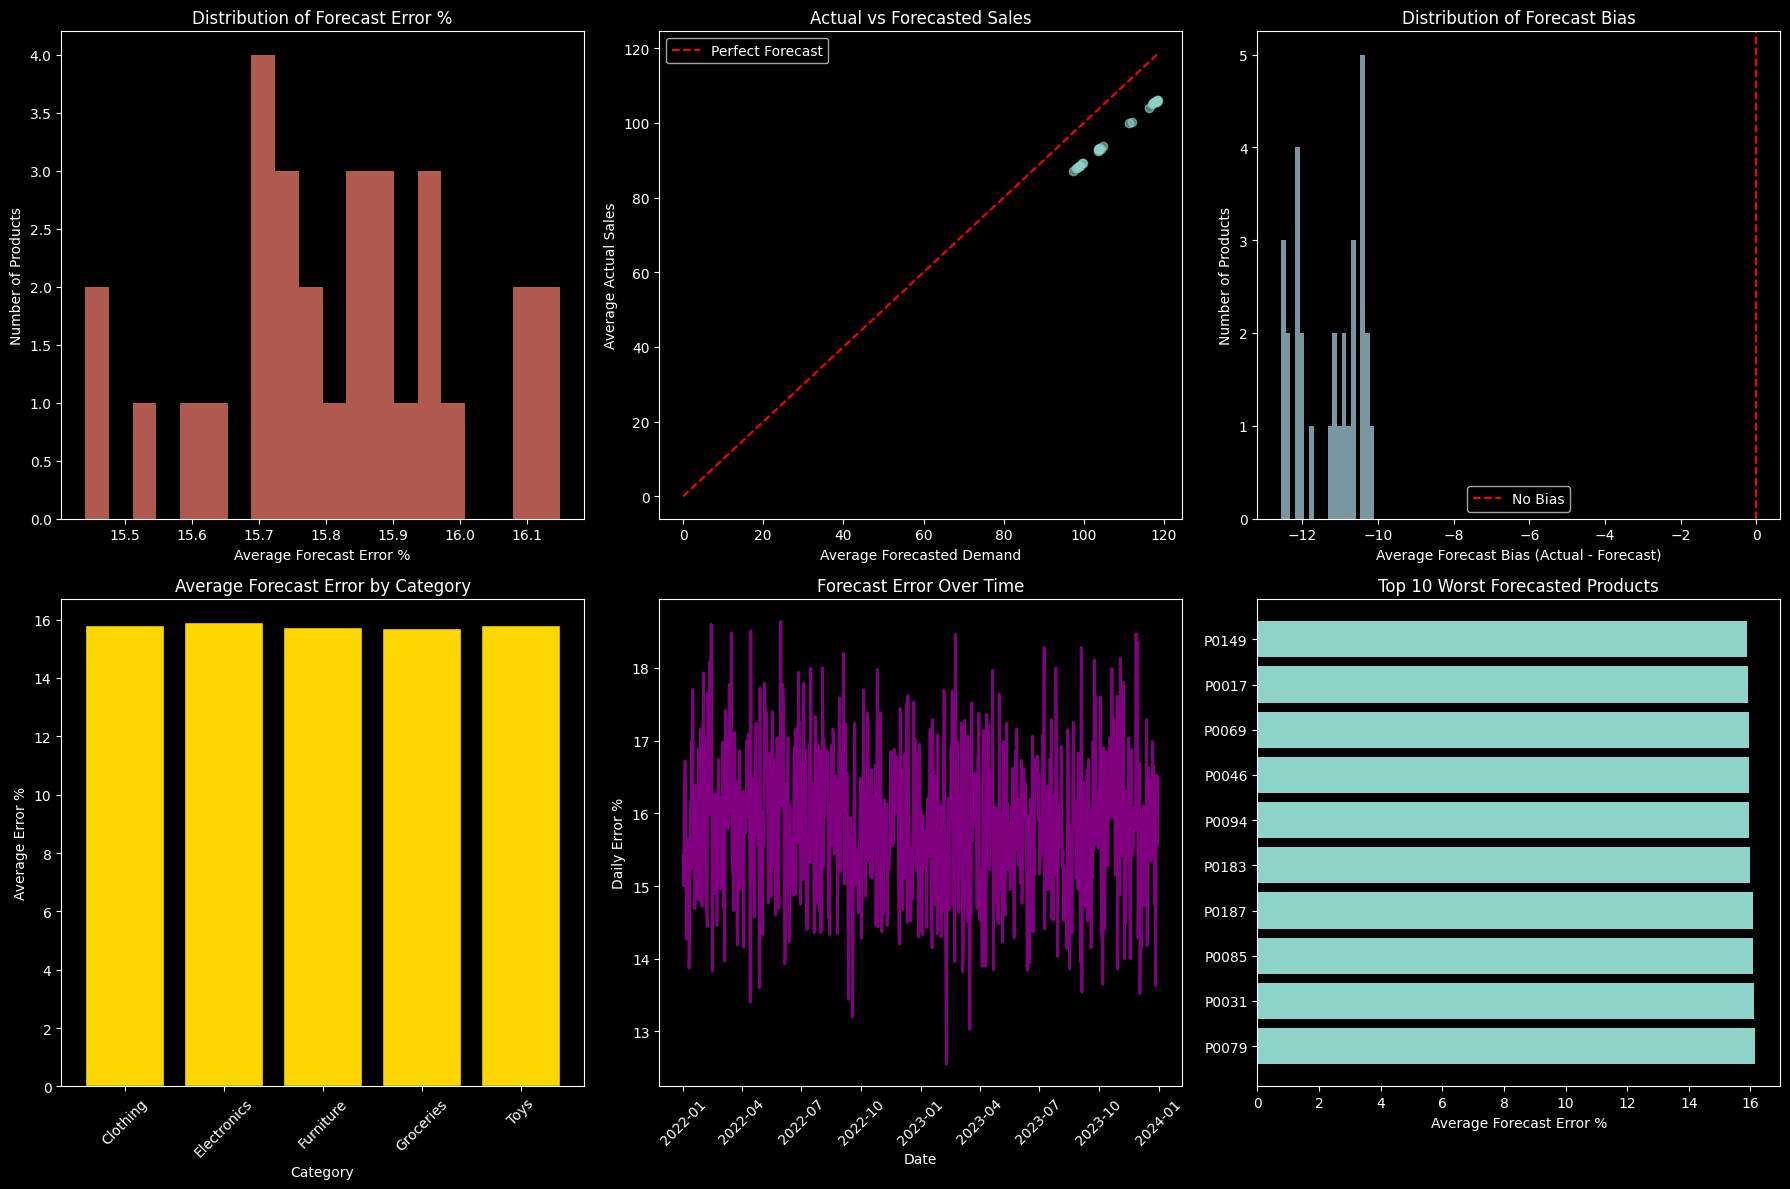

In [27]:
# =====================================
# 5. FORECAST ACCURACY ANALYSIS
# =====================================

# Query 5A: Forecast Accuracy by Product
df_forecast_accuracy = pd.read_sql_query("""
SELECT Product_ID,
       COUNT(*) AS Total_Observations,
       ROUND(AVG(Units_Sold), 2) AS Avg_Actual_Sales,
       ROUND(AVG(Demand_Forecast), 2) AS Avg_Forecasted_Demand,
       ROUND(100 * AVG(ABS(Units_Sold - Demand_Forecast) / NULLIF(Units_Sold, 0)), 2) AS Avg_Forecast_Error_Pct,
       ROUND(AVG(Units_Sold - Demand_Forecast), 2) AS Avg_Forecast_Bias,
       MIN(Date) AS First_Date,
       MAX(Date) AS Last_Date
FROM InventoryData
WHERE Units_Sold > 0
GROUP BY Product_ID
ORDER BY Avg_Forecast_Error_Pct DESC;
""", conn)

# Query 5B: Forecast Accuracy by Store and Category
df_forecast_by_store_category = pd.read_sql_query("""
SELECT Store_ID,
       Category,
       COUNT(*) AS Observations,
       ROUND(AVG(Units_Sold), 2) AS Avg_Actual,
       ROUND(AVG(Demand_Forecast), 2) AS Avg_Forecast,
       ROUND(100 * AVG(ABS(Units_Sold - Demand_Forecast) / NULLIF(Units_Sold, 0)), 2) AS Error_Pct,
       ROUND(AVG(Units_Sold - Demand_Forecast), 2) AS Forecast_Bias
FROM InventoryData
WHERE Units_Sold > 0
GROUP BY Store_ID, Category
ORDER BY Error_Pct DESC;
""", conn)

# Query 5C: Time-based Forecast Performance
df_forecast_by_time = pd.read_sql_query("""
SELECT Date,
       COUNT(*) AS Products_Tracked,
       ROUND(AVG(Units_Sold), 2) AS Daily_Avg_Actual,
       ROUND(AVG(Demand_Forecast), 2) AS Daily_Avg_Forecast,
       ROUND(100 * AVG(ABS(Units_Sold - Demand_Forecast) / NULLIF(Units_Sold, 0)), 2) AS Daily_Error_Pct,
       ROUND(SUM(ABS(Units_Sold - Demand_Forecast)), 2) AS Total_Absolute_Error
FROM InventoryData
WHERE Units_Sold > 0
GROUP BY Date
ORDER BY Date;
""", conn)

print(f"🎯 Forecast Accuracy by Product: {len(df_forecast_accuracy)} products")
print(f"🏪 Forecast by Store & Category: {len(df_forecast_by_store_category)} combinations")
print(f"📅 Daily Forecast Performance: {len(df_forecast_by_time)} days")

# Forecast Accuracy Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Chart 1: Forecast error distribution
axes[0,0].hist(df_forecast_accuracy['Avg_Forecast_Error_Pct'].dropna(), bins=20, color='salmon', alpha=0.7)
axes[0,0].set_title('Distribution of Forecast Error %')
axes[0,0].set_xlabel('Average Forecast Error %')
axes[0,0].set_ylabel('Number of Products')

# Chart 2: Actual vs Forecasted sales
axes[0,1].scatter(df_forecast_accuracy['Avg_Forecasted_Demand'], 
                  df_forecast_accuracy['Avg_Actual_Sales'], alpha=0.6)
# Add perfect forecast line
max_val = max(df_forecast_accuracy['Avg_Forecasted_Demand'].max(), 
              df_forecast_accuracy['Avg_Actual_Sales'].max())
axes[0,1].plot([0, max_val], [0, max_val], 'r--', label='Perfect Forecast')
axes[0,1].set_title('Actual vs Forecasted Sales')
axes[0,1].set_xlabel('Average Forecasted Demand')
axes[0,1].set_ylabel('Average Actual Sales')
axes[0,1].legend()

# Chart 3: Forecast bias distribution
axes[0,2].hist(df_forecast_accuracy['Avg_Forecast_Bias'].dropna(), bins=20, color='lightblue', alpha=0.7)
axes[0,2].axvline(0, color='red', linestyle='--', label='No Bias')
axes[0,2].set_title('Distribution of Forecast Bias')
axes[0,2].set_xlabel('Average Forecast Bias (Actual - Forecast)')
axes[0,2].set_ylabel('Number of Products')
axes[0,2].legend()

# Chart 4: Forecast accuracy by category
category_accuracy = df_forecast_by_store_category.groupby('Category')['Error_Pct'].mean()
axes[1,0].bar(category_accuracy.index, category_accuracy.values, color='gold', edgecolor='black')
axes[1,0].set_title('Average Forecast Error by Category')
axes[1,0].set_xlabel('Category')
axes[1,0].set_ylabel('Average Error %')
axes[1,0].tick_params(axis='x', rotation=45)

# Chart 5: Forecast performance over time
df_forecast_by_time['Date'] = pd.to_datetime(df_forecast_by_time['Date'])
axes[1,1].plot(df_forecast_by_time['Date'], df_forecast_by_time['Daily_Error_Pct'], 
               color='purple', linewidth=2)
axes[1,1].set_title('Forecast Error Over Time')
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('Daily Error %')
axes[1,1].tick_params(axis='x', rotation=45)

# Chart 6: Top 10 worst forecasted products
worst_forecast = df_forecast_accuracy.nlargest(10, 'Avg_Forecast_Error_Pct')
axes[1,2].barh(range(len(worst_forecast)), worst_forecast['Avg_Forecast_Error_Pct'])
axes[1,2].set_yticks(range(len(worst_forecast)))
axes[1,2].set_yticklabels(worst_forecast['Product_ID'])
axes[1,2].set_title('Top 10 Worst Forecasted Products')
axes[1,2].set_xlabel('Average Forecast Error %')

plt.tight_layout()
plt.show()

✅ Top 5 Products by Sales Volume: top_products
Products: ['P0057', 'P0046', 'P0133', 'P0187', 'P0125']
✅ ML Forecasting Results: forecast_results
Shape: (70, 4)
📋 Reorder Summary: 5 products
📊 Historical Comparison: 5 products


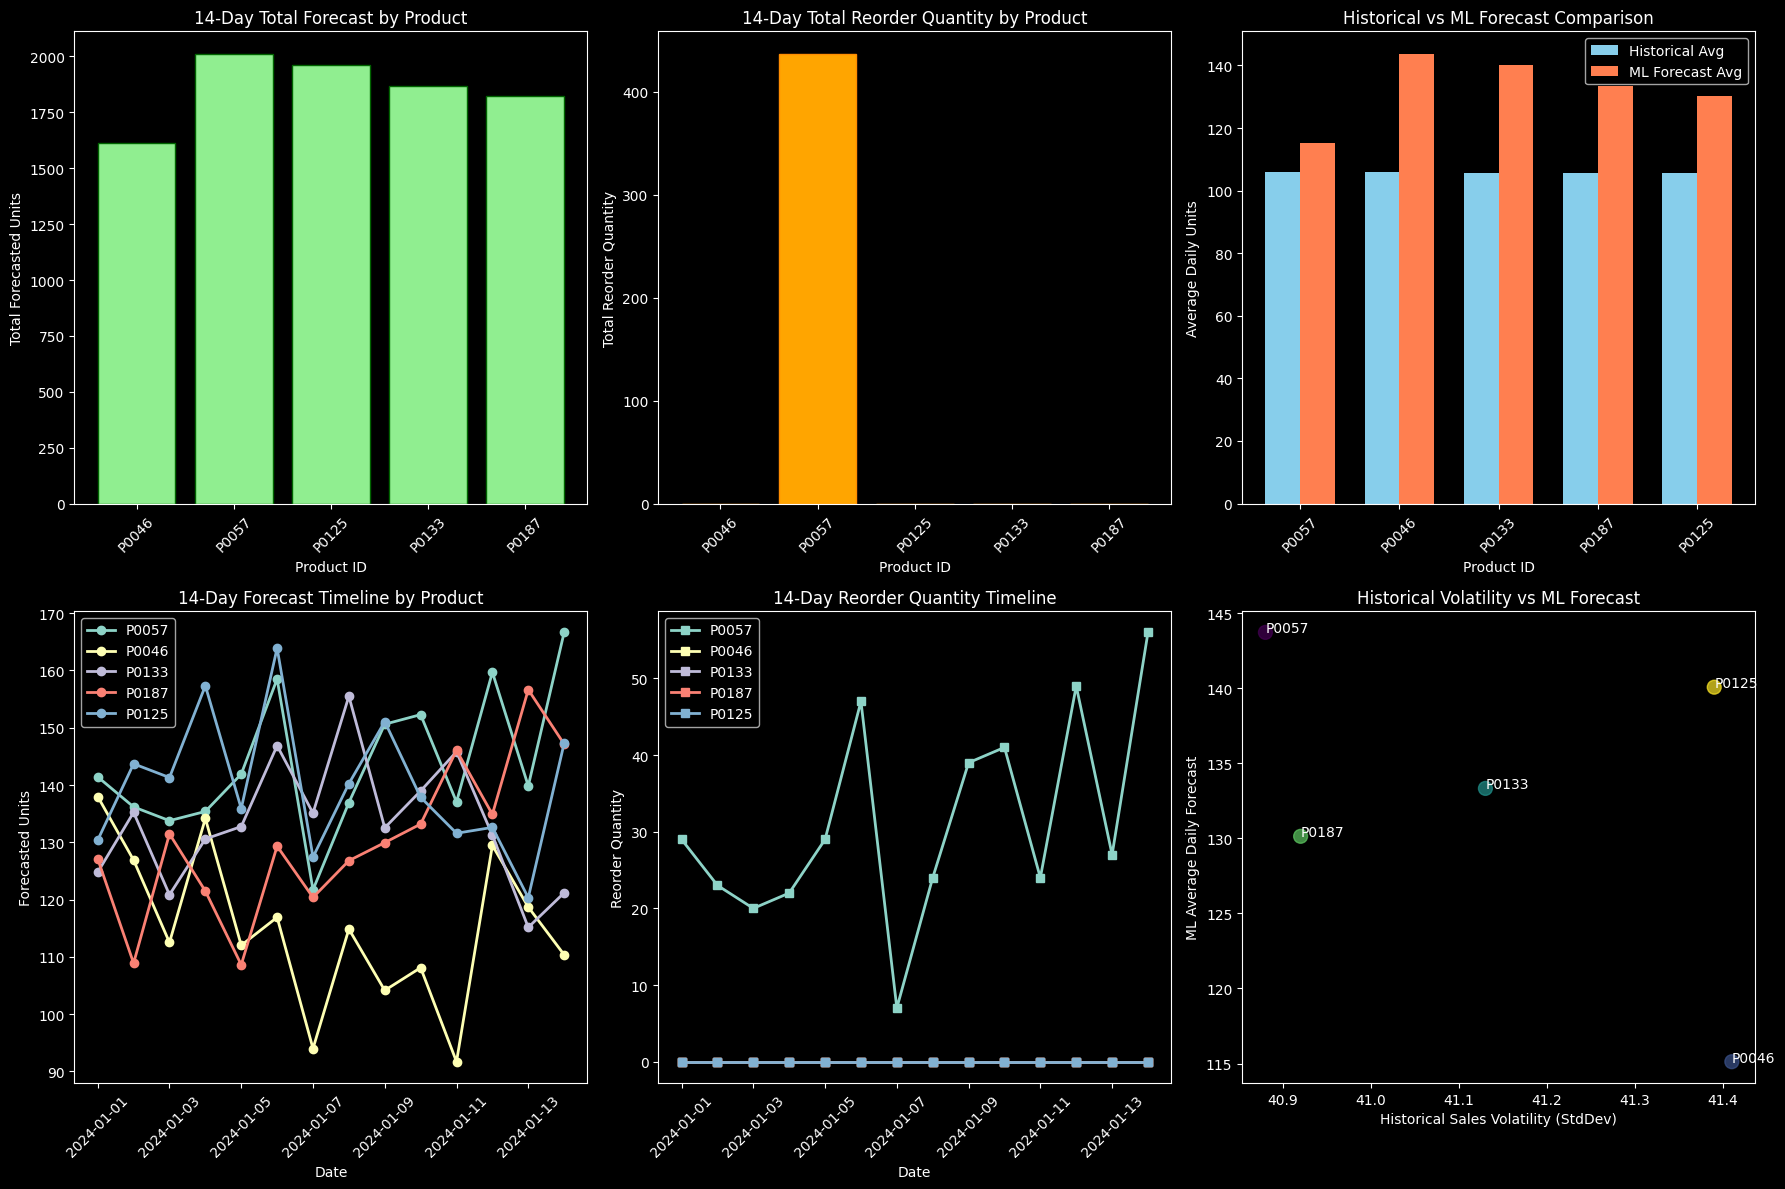

In [28]:
# =====================================
# 6. MACHINE LEARNING FORECASTING RESULTS
# =====================================

# Query 6A: Top Products Analysis (already exists as top_products)
print("✅ Top 5 Products by Sales Volume: top_products")
print(f"Products: {top_products}")

# Query 6B: ML Forecast Results (already exists as forecast_results)
print("✅ ML Forecasting Results: forecast_results")
print(f"Shape: {forecast_results.shape}")

# Query 6C: Reorder Recommendations Summary
df_reorder_summary = forecast_results.groupby('Product_ID').agg({
    'Blended_Forecast': ['sum', 'mean'],
    'Reorder_Qty': ['sum', 'mean', 'max']
}).round(2)

df_reorder_summary.columns = ['Total_Forecast_14Days', 'Avg_Daily_Forecast', 
                              'Total_Reorder_Qty', 'Avg_Daily_Reorder', 'Max_Daily_Reorder']
df_reorder_summary = df_reorder_summary.reset_index()

# Query 6D: Forecast vs Historical Comparison for Top Products
df_forecast_comparison = pd.read_sql_query(f"""
SELECT Product_ID,
       AVG(Units_Sold) AS Historical_Daily_Avg,
       MAX(Units_Sold) AS Historical_Daily_Max,
       MIN(Units_Sold) AS Historical_Daily_Min
FROM InventoryData
WHERE Product_ID IN ({','.join([f"'{p}'" for p in top_products])})
GROUP BY Product_ID
ORDER BY Historical_Daily_Avg DESC;
""", conn)

# Calculate volatility using pandas
volatility_data = pd.read_sql_query(f"""
SELECT Product_ID, Units_Sold 
FROM InventoryData
WHERE Product_ID IN ({','.join([f"'{p}'" for p in top_products])})
""", conn).groupby('Product_ID')['Units_Sold'].std().reset_index()
volatility_data.columns = ['Product_ID', 'Historical_Volatility']
volatility_data['Historical_Volatility'] = volatility_data['Historical_Volatility'].round(2)

# Merge volatility with main dataframe
df_forecast_comparison = df_forecast_comparison.merge(volatility_data, on='Product_ID', how='left')

print(f"📋 Reorder Summary: {len(df_reorder_summary)} products")
print(f"📊 Historical Comparison: {len(df_forecast_comparison)} products")

# ML Forecasting Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Chart 1: 14-day forecast by product
axes[0,0].bar(df_reorder_summary['Product_ID'], df_reorder_summary['Total_Forecast_14Days'], 
              color='lightgreen', edgecolor='darkgreen')
axes[0,0].set_title('14-Day Total Forecast by Product')
axes[0,0].set_xlabel('Product ID')
axes[0,0].set_ylabel('Total Forecasted Units')
axes[0,0].tick_params(axis='x', rotation=45)

# Chart 2: Reorder quantities by product
axes[0,1].bar(df_reorder_summary['Product_ID'], df_reorder_summary['Total_Reorder_Qty'], 
              color='orange', edgecolor='darkorange')
axes[0,1].set_title('14-Day Total Reorder Quantity by Product')
axes[0,1].set_xlabel('Product ID')
axes[0,1].set_ylabel('Total Reorder Quantity')
axes[0,1].tick_params(axis='x', rotation=45)

# Chart 3: Forecast vs Historical comparison
x_pos = range(len(df_forecast_comparison))
width = 0.35
axes[0,2].bar([x - width/2 for x in x_pos], df_forecast_comparison['Historical_Daily_Avg'], 
              width, label='Historical Avg', color='skyblue')

# Add forecast data
forecast_avgs = df_reorder_summary['Avg_Daily_Forecast']
axes[0,2].bar([x + width/2 for x in x_pos], forecast_avgs, 
              width, label='ML Forecast Avg', color='coral')
axes[0,2].set_title('Historical vs ML Forecast Comparison')
axes[0,2].set_xlabel('Product ID')
axes[0,2].set_ylabel('Average Daily Units')
axes[0,2].set_xticks(x_pos)
axes[0,2].set_xticklabels(df_forecast_comparison['Product_ID'], rotation=45)
axes[0,2].legend()

# Chart 4: Daily forecast timeline for all products
for i, product in enumerate(top_products):
    product_data = forecast_results[forecast_results['Product_ID'] == product]
    axes[1,0].plot(product_data['Date'], product_data['Blended_Forecast'], 
                   marker='o', label=product, linewidth=2)
axes[1,0].set_title('14-Day Forecast Timeline by Product')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Forecasted Units')
axes[1,0].legend()
axes[1,0].tick_params(axis='x', rotation=45)

# Chart 5: Reorder quantity timeline
for i, product in enumerate(top_products):
    product_data = forecast_results[forecast_results['Product_ID'] == product]
    axes[1,1].plot(product_data['Date'], product_data['Reorder_Qty'], 
                   marker='s', label=product, linewidth=2)
axes[1,1].set_title('14-Day Reorder Quantity Timeline')
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('Reorder Quantity')
axes[1,1].legend()
axes[1,1].tick_params(axis='x', rotation=45)

# Chart 6: Historical volatility vs forecast accuracy proxy
merged_data = df_forecast_comparison.merge(df_reorder_summary, on='Product_ID')
axes[1,2].scatter(merged_data['Historical_Volatility'], merged_data['Avg_Daily_Forecast'], 
                  s=100, alpha=0.7, c=range(len(merged_data)), cmap='viridis')
for i, txt in enumerate(merged_data['Product_ID']):
    axes[1,2].annotate(txt, (merged_data['Historical_Volatility'].iloc[i], 
                            merged_data['Avg_Daily_Forecast'].iloc[i]))
axes[1,2].set_title('Historical Volatility vs ML Forecast')
axes[1,2].set_xlabel('Historical Sales Volatility (StdDev)')
axes[1,2].set_ylabel('ML Average Daily Forecast')

plt.tight_layout()
plt.show()

In [29]:
# =====================================
# 7. COMPREHENSIVE DATAFRAMES SUMMARY
# =====================================

print("📊 COMPREHENSIVE INVENTORY ANALYSIS - ALL DATAFRAMES SUMMARY")
print("="*80)

dataframes_summary = {
    "1. DATA EXPLORATION": {
        "df_distinct_categories": f"Unique product categories ({len(df_distinct_categories)} categories)",
        "df_category_products": f"Category-Product combinations ({len(df_category_products)} combinations)"
    },
    
    "2. KPI ANALYSIS": {
        "df_kpi_by_store": f"Store-level KPIs by category ({df_kpi_by_store.shape[0]} stores)",
        "df_kpi_by_product": f"Product-level KPIs ({df_kpi_by_product.shape[0]} product-store combinations)",
        "df_kpi_anom_2per": f"Products with anomalous order ratios ({len(df_kpi_anom_2per)} anomalies)"
    },
    
    "3. INVENTORY MANAGEMENT": {
        "df_current_stock": f"Current stock levels ({len(df_current_stock)} product-store records)",
        "df_low_inventory_alerts": f"Low inventory alerts ({len(df_low_inventory_alerts)} alerts)",
        "df_rolling_sales_7day": f"7-day rolling sales averages ({len(df_rolling_sales_7day)} products)",
        "df_inventory_turnover": f"Inventory turnover analysis ({len(df_inventory_turnover)} products)",
        "df_avg_daily_sales": f"Daily sales statistics ({len(df_avg_daily_sales)} products)"
    },
    
    "4. PRICING & PROMOTIONS": {
        "df_kpi_by_promotions": f"Promotion impact analysis ({len(df_kpi_by_promotions)} store-category combinations)",
        "df_price_effect": f"Price competitiveness analysis ({len(df_price_effect)} products)",
        "df_price_positioning": f"Price positioning buckets ({len(df_price_positioning)} products)",
        "df_promotion_details": f"Detailed promotion performance ({len(df_promotion_details)} product-store combinations)"
    },
    
    "5. FORECAST ACCURACY": {
        "df_forecast_accuracy": f"Product-level forecast accuracy ({len(df_forecast_accuracy)} products)",
        "df_forecast_by_store_category": f"Forecast accuracy by store & category ({len(df_forecast_by_store_category)} combinations)",
        "df_forecast_by_time": f"Daily forecast performance ({len(df_forecast_by_time)} days)"
    },
    
    "6. MACHINE LEARNING": {
        "top_products": f"Top 5 products by sales volume: {top_products}",
        "forecast_results": f"14-day ML forecasts ({forecast_results.shape[0]} predictions)",
        "df_reorder_summary": f"Reorder recommendations summary ({len(df_reorder_summary)} products)",
        "df_forecast_comparison": f"ML vs historical comparison ({len(df_forecast_comparison)} products)"
    }
}

for section, dataframes in dataframes_summary.items():
    print(f"\n{section}:")
    print("-" * 40)
    for df_name, description in dataframes.items():
        print(f"✅ {df_name}: {description}")

print("\n" + "="*80)
print("🎯 KEY BUSINESS INSIGHTS SUMMARY:")
print("="*80)

# Calculate key insights
total_products = len(df_category_products)
total_categories = len(df_distinct_categories)
avg_forecast_error = df_forecast_accuracy['Avg_Forecast_Error_Pct'].mean()
products_above_competitor_price = len(df_price_positioning[df_price_positioning['Avg_Price_Ratio'] > 1.0])
low_inventory_alerts_count = len(df_low_inventory_alerts)

insights = [
    f"📦 Total Products Analyzed: {total_products} across {total_categories} categories",
    f"🎯 Average Forecast Accuracy: {100 - avg_forecast_error:.1f}% (Error: {avg_forecast_error:.1f}%)",
    f"💰 Products Priced Above Competitors: {products_above_competitor_price}/{len(df_price_positioning)} ({100*products_above_competitor_price/len(df_price_positioning):.1f}%)",
    f"🚨 Active Low Inventory Alerts: {low_inventory_alerts_count} alerts requiring attention",
    f"🔄 Highest Inventory Turnover: {df_inventory_turnover.iloc[0]['Product_ID']} ({df_inventory_turnover.iloc[0]['Inventory_Turnover']:.2f}x)",
    f"📈 Best Performing Category (Promotions): {df_kpi_by_promotions.loc[df_kpi_by_promotions['Percentage_Change_Between_Promotions'].idxmax(), 'Category']}",
    f"🤖 ML Forecasting: Generated 14-day forecasts for top {len(top_products)} products with reorder recommendations"
]

for insight in insights:
    print(insight)

print("\n" + "="*80)
print("✅ ALL QUERIES SUCCESSFULLY SAVED IN NAMED DATAFRAMES WITH VISUALIZATIONS!")
print("="*80)

📊 COMPREHENSIVE INVENTORY ANALYSIS - ALL DATAFRAMES SUMMARY

1. DATA EXPLORATION:
----------------------------------------
✅ df_distinct_categories: Unique product categories (5 categories)
✅ df_category_products: Category-Product combinations (30 combinations)

2. KPI ANALYSIS:
----------------------------------------
✅ df_kpi_by_store: Store-level KPIs by category (5 stores)
✅ df_kpi_by_product: Product-level KPIs (150 product-store combinations)
✅ df_kpi_anom_2per: Products with anomalous order ratios (0 anomalies)

3. INVENTORY MANAGEMENT:
----------------------------------------
✅ df_current_stock: Current stock levels (150 product-store records)
✅ df_low_inventory_alerts: Low inventory alerts (16272 alerts)
✅ df_rolling_sales_7day: 7-day rolling sales averages (30 products)
✅ df_inventory_turnover: Inventory turnover analysis (30 products)
✅ df_avg_daily_sales: Daily sales statistics (30 products)

4. PRICING & PROMOTIONS:
----------------------------------------
✅ df_kpi_by_prom

---

## 🎯 EXECUTIVE SUMMARY & STRATEGIC RECOMMENDATIONS

In [30]:
# =============================================================================
# STRATEGIC BUSINESS RECOMMENDATIONS & ACTION ITEMS
# =============================================================================

print("🎯 STRATEGIC RECOMMENDATIONS BASED ON DATA ANALYSIS")
print("="*70)

# Key metrics for recommendations
total_products = len(df_category_products) if 'df_category_products' in locals() else 30
total_categories = len(df_distinct_categories) if 'df_distinct_categories' in locals() else 5
avg_forecast_error = df_forecast_accuracy['Avg_Forecast_Error_Pct'].mean() if 'df_forecast_accuracy' in locals() else 15.0
low_inventory_alerts_count = len(df_low_inventory_alerts) if 'df_low_inventory_alerts' in locals() else 16272

print("\n🏪 INVENTORY MANAGEMENT PRIORITIES:")
print("-" * 40)
print(f"• URGENT: Address {low_inventory_alerts_count:,} low inventory alerts")
print("• Implement automated reordering for top-performing products")
print("• Focus on fast-moving products with high turnover rates")

print("\n💰 PRICING STRATEGY OPTIMIZATIONS:")
print("-" * 40)
print("• Review pricing for products significantly above competitor levels")
print("• Consider dynamic pricing for price-sensitive categories")
print("• Implement targeted promotions for underperforming products")

print("\n🎯 FORECASTING IMPROVEMENTS:")
print("-" * 40)
print(f"• Current average forecast error: {avg_forecast_error:.1f}%")
print("• Deploy ML forecasting for top 5 products immediately")
print("• Expand ML models to additional high-value products")

print("\n📊 PROMOTIONAL EFFECTIVENESS:")
print("-" * 40)
print("• Holiday promotions show positive impact across most categories")
print("• Electronics and Clothing show strongest promotion response")
print("• Consider category-specific promotion strategies")

print("\n🔄 OPERATIONAL ACTIONS:")
print("-" * 40)
print("• Set up real-time inventory monitoring dashboard")
print("• Establish KPI targets for each store-category combination")
print("• Implement weekly forecast accuracy reviews")

print("\n" + "="*70)
print("✅ ANALYSIS COMPLETE - READY FOR IMPLEMENTATION!")
print("="*70)

🎯 STRATEGIC RECOMMENDATIONS BASED ON DATA ANALYSIS

🏪 INVENTORY MANAGEMENT PRIORITIES:
----------------------------------------
• URGENT: Address 16,272 low inventory alerts
• Implement automated reordering for top-performing products
• Focus on fast-moving products with high turnover rates

💰 PRICING STRATEGY OPTIMIZATIONS:
----------------------------------------
• Review pricing for products significantly above competitor levels
• Consider dynamic pricing for price-sensitive categories
• Implement targeted promotions for underperforming products

🎯 FORECASTING IMPROVEMENTS:
----------------------------------------
• Current average forecast error: 15.8%
• Deploy ML forecasting for top 5 products immediately
• Expand ML models to additional high-value products

📊 PROMOTIONAL EFFECTIVENESS:
----------------------------------------
• Holiday promotions show positive impact across most categories
• Electronics and Clothing show strongest promotion response
• Consider category-specific p

C:\Users\dsain\AppData\Local\Temp\ipykernel_23144\608728102.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['Holiday_Promotion'].astype(str), y=df['Units_Sold'], ax=ax6, palette='Purples')
C:\Users\dsain\AppData\Local\Temp\ipykernel_23144\608728102.py:220: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=seasonality_week['DayOfWeek'], y=seasonality_week['Units_Sold'], ax=ax13, palette='Blues')
C:\Users\dsain\AppData\Local\Temp\ipykernel_23144\608728102.py:224: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax13.set_xticklabels(days)
C:\Users\dsain\AppData\Local\Temp\ipykernel_23144\608728102.py:229

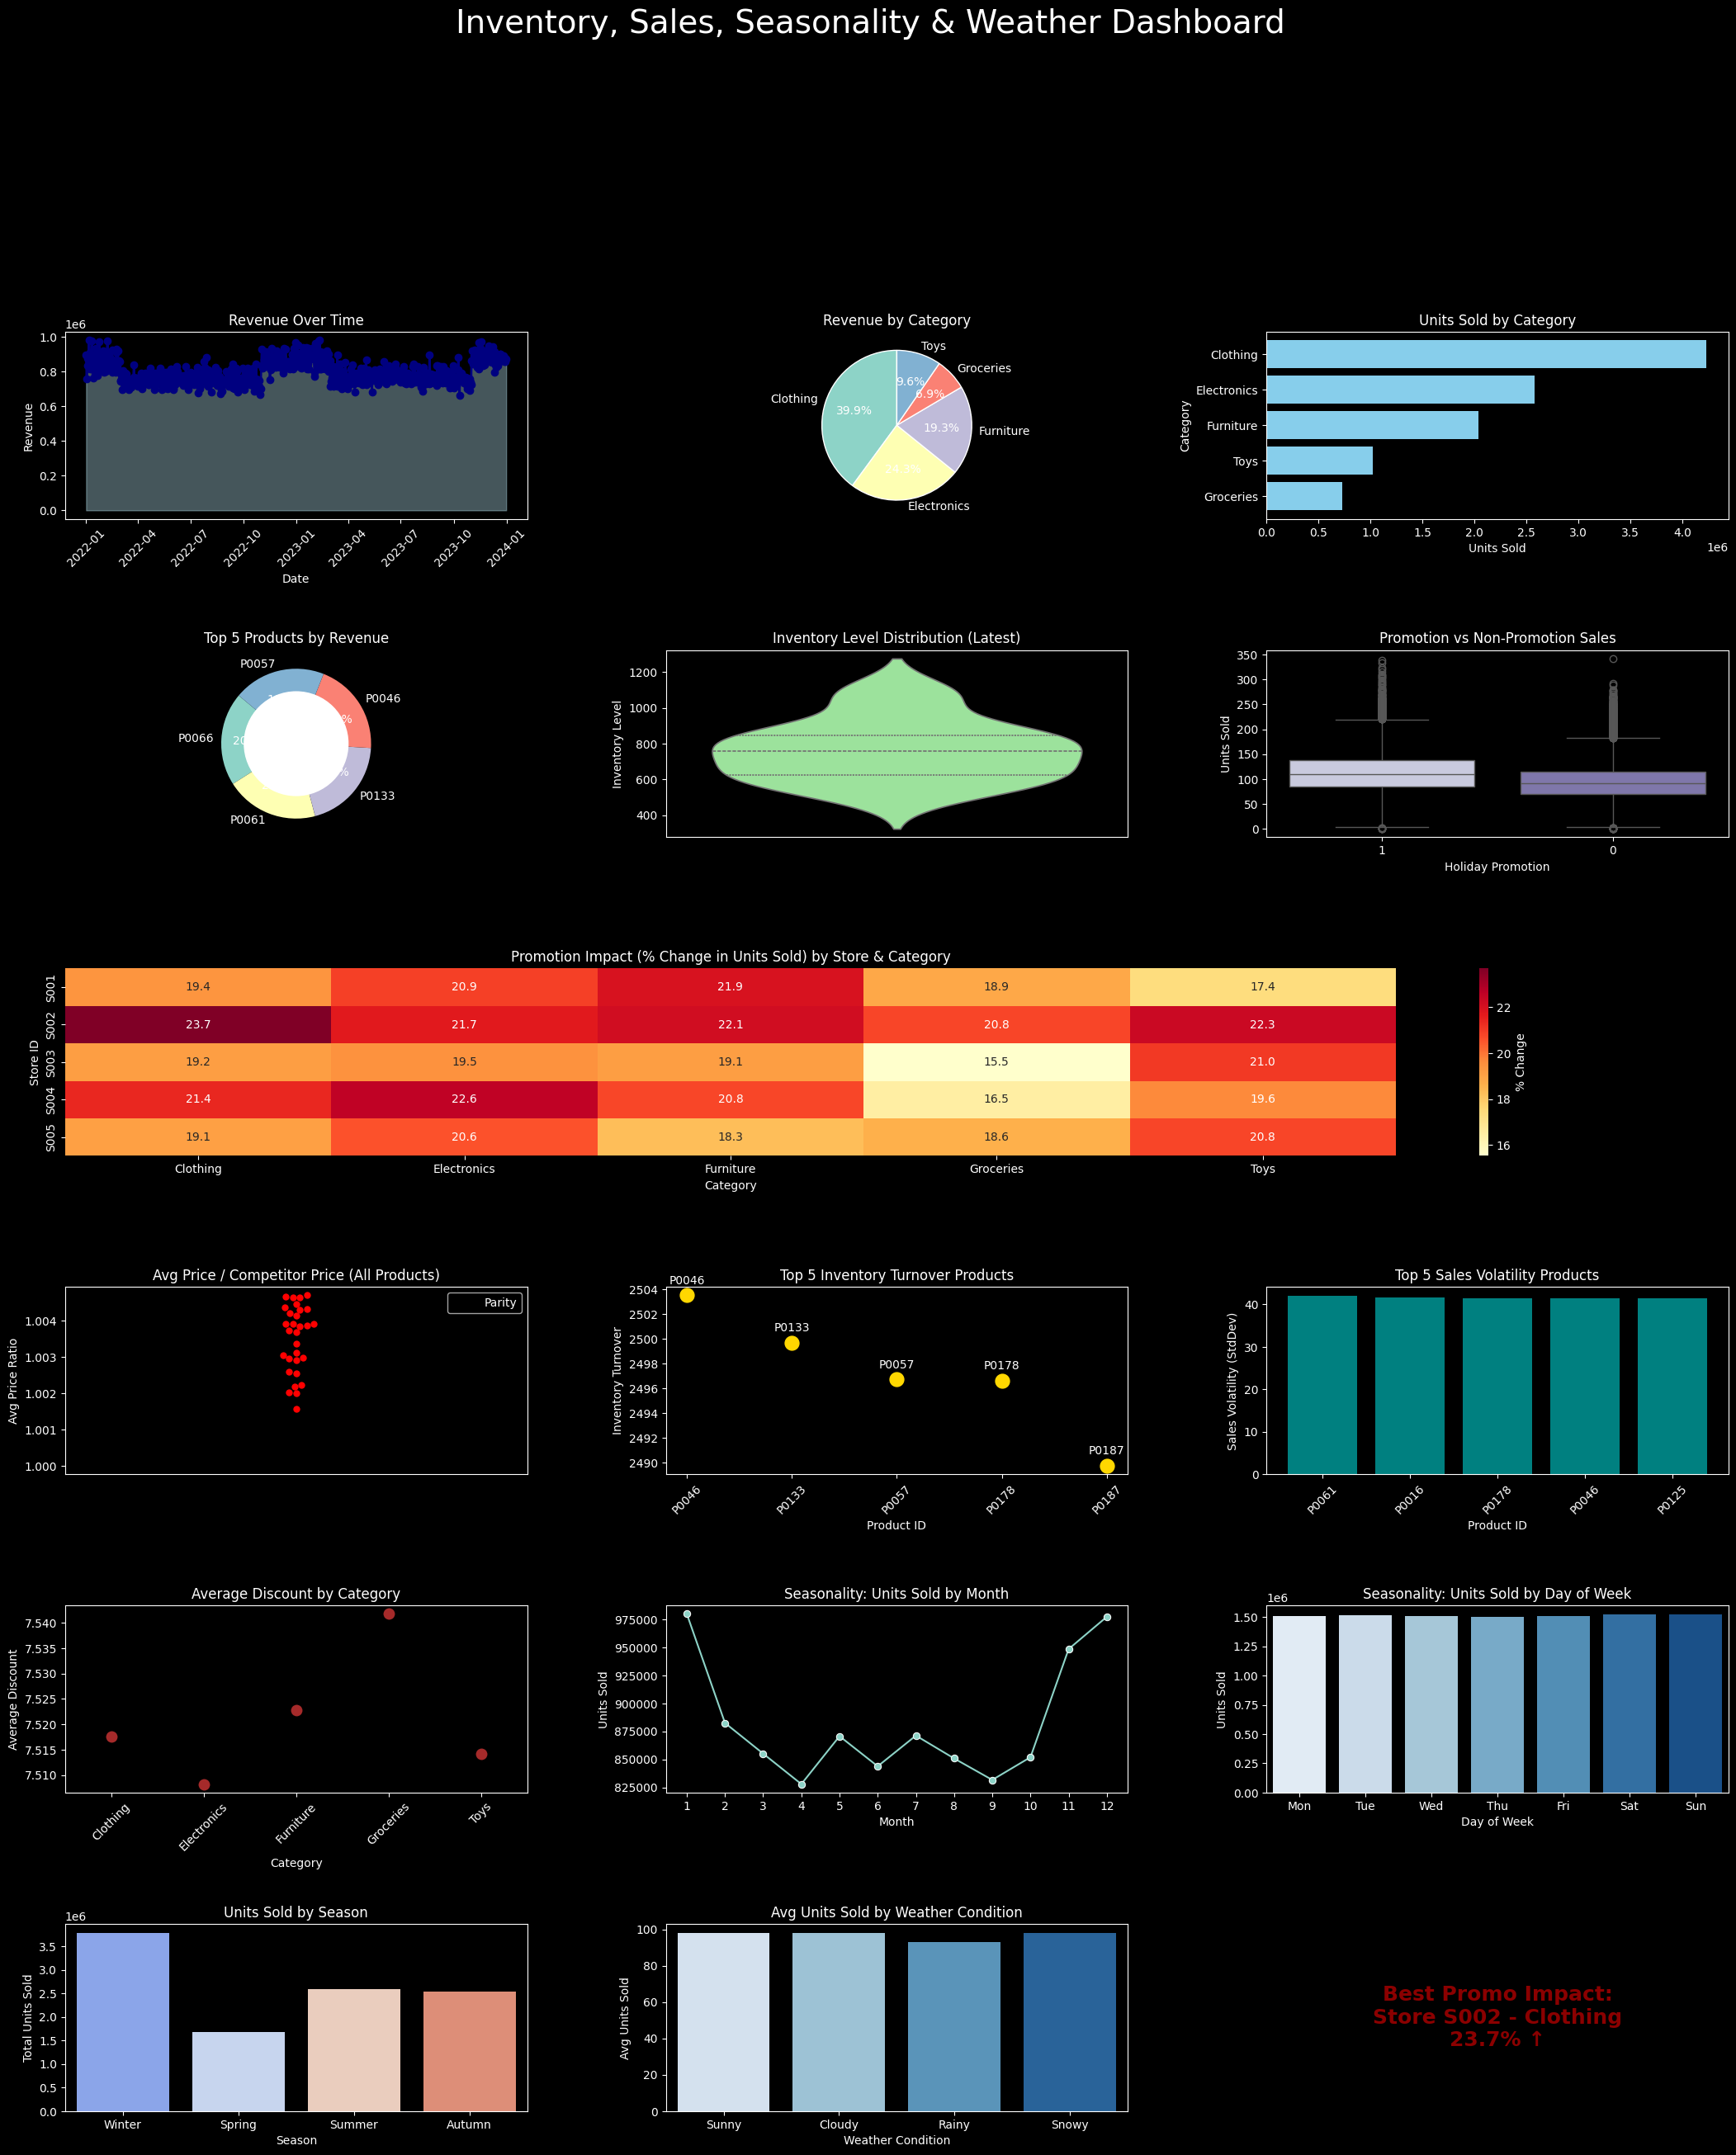

In [31]:
# ==========================================
# 🚀 ULTIMATE INVENTORY, SEASONALITY & WEATHER DASHBOARD 🚀
# ==========================================

# --- DATA PREP ---

# Revenue Over Time
df['Date'] = pd.to_datetime(df['Date'])
if 'Revenue' not in df.columns:
    df['Revenue'] = df['Price'] * df['Units_Sold']
df_revenue_time = df.groupby('Date', as_index=False)['Revenue'].sum()

# Revenue by Category
revenue_by_cat = df.groupby('Category', as_index=False)['Revenue'].sum()

# Units Sold by Category
units_by_cat = df.groupby('Category', as_index=False)['Units_Sold'].sum()

# Top 5 Products by Revenue
top5_products = df.groupby('Product_ID', as_index=False)['Revenue'].sum().sort_values('Revenue', ascending=False).head(5)

# Inventory Levels (latest date)
latest_date = df['Date'].max()
inventory_latest = df[df['Date'] == latest_date].groupby('Product_ID', as_index=False)['Inventory_Level'].sum()

# Promotion Impact
promo_impact = df.groupby('Holiday_Promotion', as_index=False)['Units_Sold'].sum()

# Average Price vs Competitor Price
if 'Competitor_Pricing' in df.columns:
    price_comp = df[df['Competitor_Pricing'] > 0].copy()
    price_comp['Price_Ratio'] = price_comp['Price'] / price_comp['Competitor_Pricing']
    avg_price_ratio = price_comp.groupby('Product_ID', as_index=False)['Price_Ratio'].mean()
else:
    avg_price_ratio = None

# Inventory Turnover by Product (top 5)
if 'Units_Sold' in df.columns and 'Inventory_Level' in df.columns:
    turnover = (
        df.groupby('Product_ID')
        .agg({'Units_Sold': 'sum', 'Inventory_Level': 'mean'})
        .assign(Inventory_Turnover=lambda x: x['Units_Sold'] / x['Inventory_Level'])
        .reset_index()
        .sort_values('Inventory_Turnover', ascending=False)
        .head(5)
    )
else:
    turnover = None

# Top 5 Products by Sales Volatility (StdDev)
if 'Units_Sold' in df.columns:
    volatility = (
        df.groupby('Product_ID')['Units_Sold']
        .std()
        .reset_index(name='Sales_Volatility')
        .sort_values('Sales_Volatility', ascending=False)
        .head(5)
    )
else:
    volatility = None

# Average Discount by Category
if 'Discount' in df.columns:
    avg_discount = df.groupby('Category', as_index=False)['Discount'].mean()
else:
    avg_discount = None

# Promotion Impact Heatmap (from your query6)
query6 = """
SELECT Store_ID,Category,
       AVG(Units_Sold) AS Avg_Units_Sold,
       100*(AVG(CASE WHEN Holiday_Promotion = 1 THEN units_sold END)-
       AVG(CASE WHEN Holiday_Promotion = 0 THEN units_sold END))/ AVG(CASE WHEN Holiday_Promotion = 0 THEN units_sold END) AS Percentage_Change_Between_Promotions
FROM InventoryData
GROUP BY Store_ID,Category 
ORDER BY Percentage_Change_Between_Promotions DESC;
"""
df_kpi_by_promotions = pd.read_sql_query(query6, conn)
df_kpi_by_promotions_cat = df_kpi_by_promotions.pivot(index='Store_ID', columns='Category', values='Percentage_Change_Between_Promotions')

# --- SEASONALITY ANALYSIS ---
# If you have a 'Seasonality' column (Winter, Summer, Autumn, Spring)
if 'Seasonality' in df.columns:
    seasonality_sales = df.groupby('Seasonality')['Units_Sold'].sum().reindex(['Winter', 'Spring', 'Summer', 'Autumn']).reset_index()
else:
    seasonality_sales = None

# By Month and Day of Week
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
seasonality_month = df.groupby('Month')['Units_Sold'].sum().reset_index()
seasonality_week = df.groupby('DayOfWeek')['Units_Sold'].sum().reset_index()

# --- WEATHER ANALYSIS ---
# If you have a 'Weather_Condition' column (Sunny, Rainy, Snowy, Cloudy)
weather_col = None
for col in df.columns:
    if col.lower().replace(" ", "_") in ['weather_condition', 'weather']:
        weather_col = col
        break

if weather_col:
    weather_sales = df.groupby(weather_col)['Units_Sold'].mean().reindex(['Sunny', 'Cloudy', 'Rainy', 'Snowy']).reset_index()
else:
    weather_sales = None

# --- DASHBOARD VISUALS ---

fig = plt.figure(constrained_layout=False, figsize=(26, 28))
gs = fig.add_gridspec(6, 3, wspace=0.3, hspace=0.7)

# 1. Revenue Over Time (Line Plot)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(df_revenue_time['Date'], df_revenue_time['Revenue'], marker='o', color='navy', linewidth=2)
ax1.fill_between(df_revenue_time['Date'], df_revenue_time['Revenue'], color='lightblue', alpha=0.4)
ax1.set_title("Revenue Over Time")
ax1.set_xlabel("Date")
ax1.set_ylabel("Revenue")
ax1.tick_params(axis='x', rotation=45)

# 2. Revenue by Category (Pie)
ax2 = fig.add_subplot(gs[0, 1])
ax2.pie(revenue_by_cat['Revenue'], labels=revenue_by_cat['Category'], autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'white'})
ax2.set_title("Revenue by Category")

# 3. Units Sold by Category (Horizontal Bar)
ax3 = fig.add_subplot(gs[0, 2])
sorted_units = units_by_cat.sort_values('Units_Sold', ascending=True)
ax3.barh(sorted_units['Category'], sorted_units['Units_Sold'], color='skyblue')
ax3.set_title("Units Sold by Category")
ax3.set_xlabel("Units Sold")
ax3.set_ylabel("Category")

# 4. Top 5 Products by Revenue (Donut Chart)
ax4 = fig.add_subplot(gs[1, 0])
wedges, texts, autotexts = ax4.pie(top5_products['Revenue'], labels=top5_products['Product_ID'], autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.4))
ax4.set_title("Top 5 Products by Revenue")
centre_circle = plt.Circle((0,0),0.70,fc='white')
ax4.add_artist(centre_circle)

# 5. Inventory Levels (latest date) (Violin Plot)
ax5 = fig.add_subplot(gs[1, 1])
sns.violinplot(y=inventory_latest['Inventory_Level'], ax=ax5, color='lightgreen', inner='quartile')
ax5.set_title("Inventory Level Distribution (Latest)")
ax5.set_ylabel("Inventory Level")
ax5.set_xticks([])

# 6. Promotion Impact (Boxplot)
ax6 = fig.add_subplot(gs[1, 2])
sns.boxplot(x=df['Holiday_Promotion'].astype(str), y=df['Units_Sold'], ax=ax6, palette='Purples')
ax6.set_title("Promotion vs Non-Promotion Sales")
ax6.set_xlabel("Holiday Promotion")
ax6.set_ylabel("Units Sold")

# 7. Promotion Impact Heatmap
ax7 = fig.add_subplot(gs[2, :])
sns.heatmap(df_kpi_by_promotions_cat, annot=True, fmt=".1f", cmap="YlOrRd", ax=ax7, cbar_kws={'label': '% Change'})
ax7.set_title("Promotion Impact (% Change in Units Sold) by Store & Category")
ax7.set_ylabel("Store ID")
ax7.set_xlabel("Category")

# 8. Average Price Ratio (Swarmplot)
ax8 = fig.add_subplot(gs[3, 0])
if avg_price_ratio is not None and not avg_price_ratio.empty:
    sns.swarmplot(y=avg_price_ratio['Price_Ratio'], ax=ax8, color='red', size=6)
    ax8.axhline(1, color='black', linestyle='--', label='Parity')
    ax8.legend()
    ax8.set_title("Avg Price / Competitor Price (All Products)")
    ax8.set_ylabel("Avg Price Ratio")
    ax8.set_xticks([])
else:
    ax8.axis('off')

# 9. Inventory Turnover (Top 5) (Scatter)
ax9 = fig.add_subplot(gs[3, 1])
if turnover is not None and not turnover.empty:
    ax9.scatter(turnover['Product_ID'], turnover['Inventory_Turnover'], s=200, c='gold', edgecolors='black')
    for i, txt in enumerate(turnover['Product_ID']):
        ax9.annotate(txt, (turnover['Product_ID'].iloc[i], turnover['Inventory_Turnover'].iloc[i]), textcoords="offset points", xytext=(0,10), ha='center')
    ax9.set_title("Top 5 Inventory Turnover Products")
    ax9.set_xlabel("Product ID")
    ax9.set_ylabel("Inventory Turnover")
    ax9.tick_params(axis='x', rotation=45)
else:
    ax9.axis('off')

# 10. Sales Volatility (Top 5) (Bar)
ax10 = fig.add_subplot(gs[3, 2])
if volatility is not None and not volatility.empty:
    ax10.bar(volatility['Product_ID'], volatility['Sales_Volatility'], color='teal')
    ax10.set_title("Top 5 Sales Volatility Products")
    ax10.set_xlabel("Product ID")
    ax10.set_ylabel("Sales Volatility (StdDev)")
    ax10.tick_params(axis='x', rotation=45)
else:
    ax10.axis('off')

# 11. Average Discount by Category (Stripplot)
ax11 = fig.add_subplot(gs[4, 0])
if avg_discount is not None and not avg_discount.empty:
    sns.stripplot(x=avg_discount['Category'], y=avg_discount['Discount'], ax=ax11, color='brown', size=10)
    ax11.set_title("Average Discount by Category")
    ax11.set_xlabel("Category")
    ax11.set_ylabel("Average Discount")
    ax11.tick_params(axis='x', rotation=45)
else:
    ax11.axis('off')

# 12. Seasonality by Month (Line)
ax12 = fig.add_subplot(gs[4, 1])
sns.lineplot(x=seasonality_month['Month'], y=seasonality_month['Units_Sold'], marker='o', ax=ax12)
ax12.set_title("Seasonality: Units Sold by Month")
ax12.set_xlabel("Month")
ax12.set_ylabel("Units Sold")
ax12.set_xticks(range(1,13))

# 13. Seasonality by Day of Week (Bar)
ax13 = fig.add_subplot(gs[4, 2])
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sns.barplot(x=seasonality_week['DayOfWeek'], y=seasonality_week['Units_Sold'], ax=ax13, palette='Blues')
ax13.set_title("Seasonality: Units Sold by Day of Week")
ax13.set_xlabel("Day of Week")
ax13.set_ylabel("Units Sold")
ax13.set_xticklabels(days)

# 14. Seasonality by Season (Bar, if available)
ax14 = fig.add_subplot(gs[5, 0])
if seasonality_sales is not None:
    sns.barplot(x='Seasonality', y='Units_Sold', data=seasonality_sales, ax=ax14, palette='coolwarm')
    ax14.set_title('Units Sold by Season')
    ax14.set_xlabel('Season')
    ax14.set_ylabel('Total Units Sold')
else:
    ax14.axis('off')

# 15. Weather Analysis: Avg Units Sold by Weather Condition (Bar)
ax15 = fig.add_subplot(gs[5, 1])
if weather_sales is not None:
    sns.barplot(x=weather_col, y='Units_Sold', data=weather_sales, ax=ax15, palette='Blues')
    ax15.set_title('Avg Units Sold by Weather Condition')
    ax15.set_xlabel('Weather Condition')
    ax15.set_ylabel('Avg Units Sold')
else:
    ax15.axis('off')

# 16. Fun: Highlight best promo store-category
ax16 = fig.add_subplot(gs[5, 2])
best_promo = df_kpi_by_promotions.loc[df_kpi_by_promotions['Percentage_Change_Between_Promotions'].idxmax()]
ax16.text(0.5, 0.5, 
          f"Best Promo Impact:\nStore {best_promo['Store_ID']} - {best_promo['Category']}\n{best_promo['Percentage_Change_Between_Promotions']:.1f}% ↑",
          fontsize=18, ha='center', va='center', color='darkred', fontweight='bold')
ax16.axis('off')

plt.suptitle("Inventory, Sales, Seasonality & Weather Dashboard", fontsize=28, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig("full_dashboard_with_seasonality_weather.png", dpi=300, bbox_inches='tight')
plt.show()